## **Import the Data**

**If running from colab**

In [206]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


In [207]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [208]:
df = pd.read_csv("/content/drive/MyDrive/ML Project/data/train.csv") #put your path here
df_test = pd.read_csv("/content/drive/MyDrive/ML Project/data/test.csv")
#df_sub= pd.read_csv("/content/drive/MyDrive/ML Project/data/submission.csv")
df = df.drop(columns=["Unnamed: 0"])

**If running locally**

In [209]:
#df = pd.read_csv("data/train.csv") #put your path here
#df_test = pd.read_csv("data/test.csv")
##df_sub = pd.read_csv("data/submission.csv")
#df = df.drop(columns=["Unnamed: 0"])

# Feature engineering

In [210]:
#create CreditUtilizationRatio, Young and LatePaymentsFrequency
df['CreditUtilizationRatio'] = df['RevolvingUtilizationOfUnsecuredLines'] / (1 + df['DebtRatio'])

age_threshold = 30
df['Young'] = (df['age'] <= age_threshold).astype(int)

df['LatePaymentsFrequency'] = df[['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']].sum(axis=1)

In [211]:
df_test['CreditUtilizationRatio'] = df_test['RevolvingUtilizationOfUnsecuredLines'] / (1 + df_test['DebtRatio'])

age_threshold = 30
df_test['Young'] = (df_test['age'] <= age_threshold).astype(int)

df_test['LatePaymentsFrequency'] = df_test[['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']].sum(axis=1)

# NA analysis and imputation

In [212]:
for column in df.columns:
    missing = df[column].isna().sum() / df.shape[0]
    print(f"{column:{40}}: ==============> {missing * 100:.2f}%   -->   {df[column].isna().sum()}")

SeriousDlqin2yrs                        : ==============> 0.00%   -->   0
RevolvingUtilizationOfUnsecuredLines    : ==============> 0.00%   -->   0
age                                     : ==============> 0.00%   -->   0
NumberOfTime30-59DaysPastDueNotWorse    : ==============> 0.00%   -->   0
DebtRatio                               : ==============> 0.00%   -->   0
MonthlyIncome                           : ==============> 19.72%   -->   22187
NumberOfOpenCreditLinesAndLoans         : ==============> 0.00%   -->   0
NumberOfTimes90DaysLate                 : ==============> 0.00%   -->   0
NumberRealEstateLoansOrLines            : ==============> 0.00%   -->   0
NumberOfTime60-89DaysPastDueNotWorse    : ==============> 0.00%   -->   0
NumberOfDependents                      : ==============> 2.62%   -->   2945
CreditUtilizationRatio                  : ==============> 0.00%   -->   0
Young                                   : ==============> 0.00%   -->   0
LatePaymentsFrequency         

Only MonthlyIncome and NumberOfDependents display any missing data. Now we want to find whether there is a missing pattern or they are just Random Missing Data.

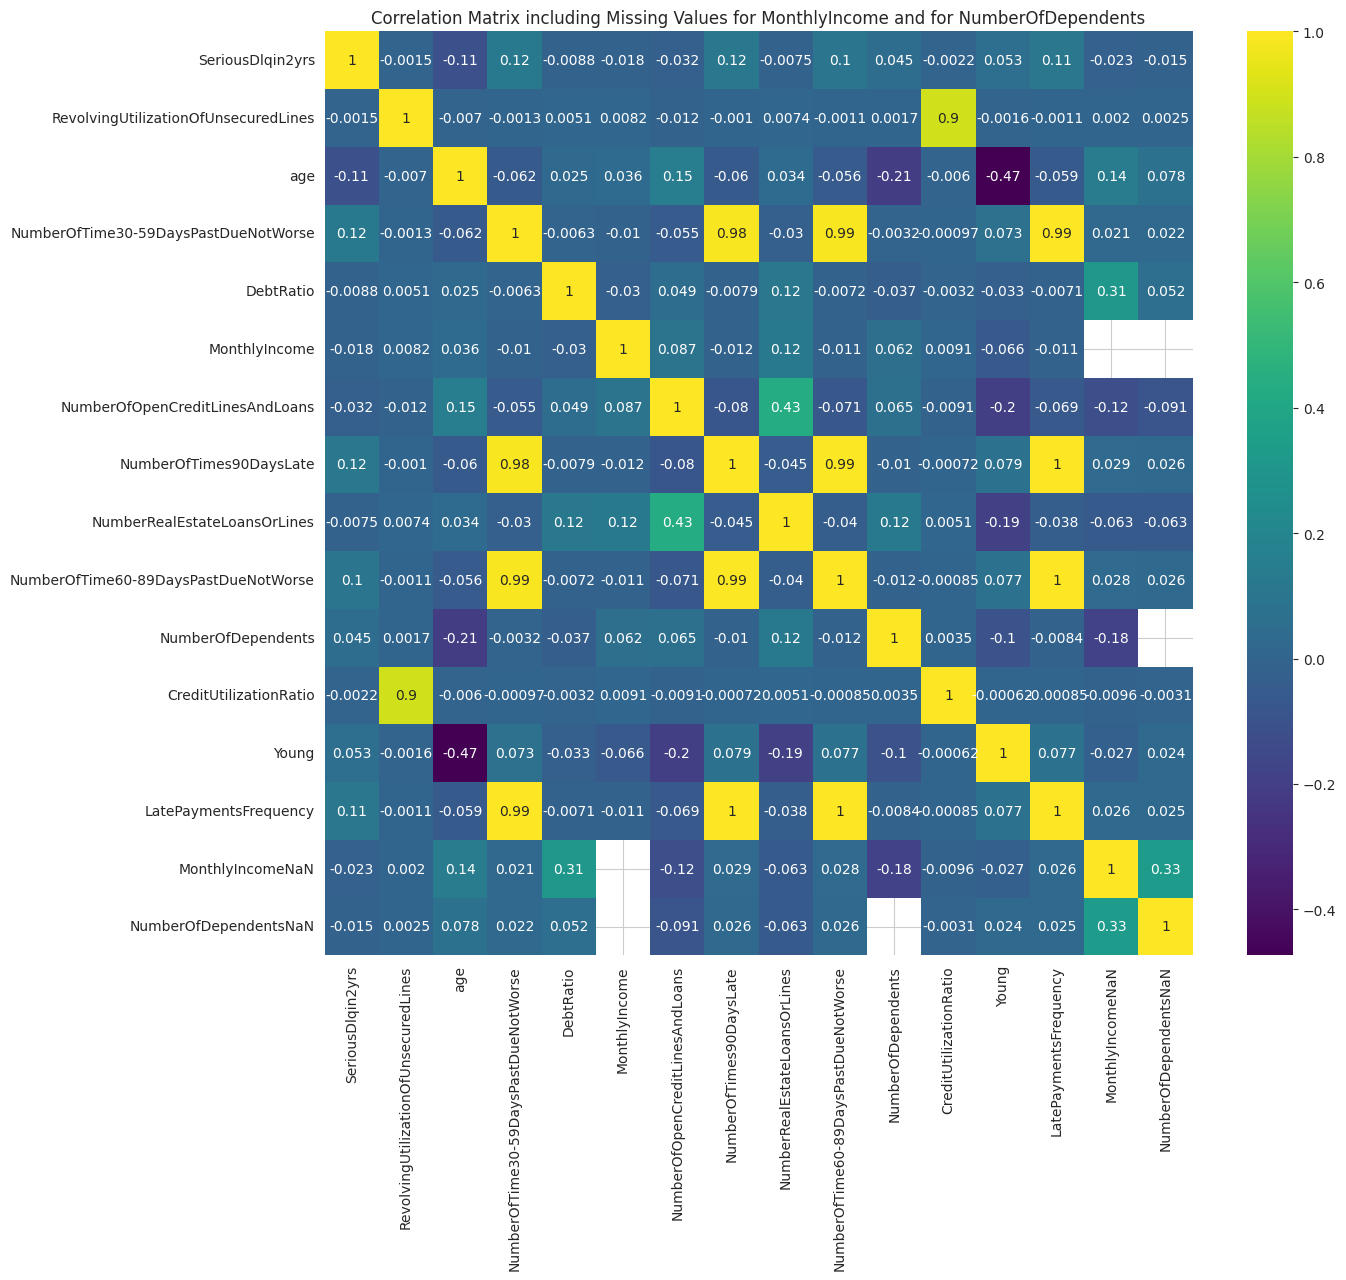

In [213]:
missing_income_df = df[['MonthlyIncome']].isnull().astype(int)
missing_income_df = missing_income_df.rename(columns={'MonthlyIncome': 'MonthlyIncomeNaN'})

missing_dependents_df = df[['NumberOfDependents']].isnull().astype(int)
missing_dependents_df = missing_dependents_df.rename(columns={'NumberOfDependents': 'NumberOfDependentsNaN'})

df_concatenated = pd.concat([df, missing_income_df, missing_dependents_df], axis=1)

plt.figure(figsize=(14, 12))
sns.heatmap(df_concatenated.corr(), cmap='viridis', annot=True) #plot a heatmap of the correlations
plt.title('Correlation Matrix including Missing Values for MonthlyIncome and for NumberOfDependents')
plt.show()

There does not seem to be a clear missing pattern. We are going to handle the missing values in two ways:
1) Since MonthlyIncome is an integer value, we will replace the nulls with the median values.
2) Number of Dependents can be characterized as a categorical variable, hence if customers have NA for number of dependents, it means that they do not have any dependents. Therefore, we fill them with zeros

In [214]:
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
df['NumberOfDependents'].fillna(0, inplace = True)

In [215]:
for column in df.columns:
    missing = df[column].isna().sum() / df.shape[0]
    print(f"{column:{40}}: ==============> {missing * 100:.2f}%   -->   {df[column].isna().sum()}")

SeriousDlqin2yrs                        : ==============> 0.00%   -->   0
RevolvingUtilizationOfUnsecuredLines    : ==============> 0.00%   -->   0
age                                     : ==============> 0.00%   -->   0
NumberOfTime30-59DaysPastDueNotWorse    : ==============> 0.00%   -->   0
DebtRatio                               : ==============> 0.00%   -->   0
MonthlyIncome                           : ==============> 0.00%   -->   0
NumberOfOpenCreditLinesAndLoans         : ==============> 0.00%   -->   0
NumberOfTimes90DaysLate                 : ==============> 0.00%   -->   0
NumberRealEstateLoansOrLines            : ==============> 0.00%   -->   0
NumberOfTime60-89DaysPastDueNotWorse    : ==============> 0.00%   -->   0
NumberOfDependents                      : ==============> 0.00%   -->   0
CreditUtilizationRatio                  : ==============> 0.00%   -->   0
Young                                   : ==============> 0.00%   -->   0
LatePaymentsFrequency                 

# Split data for cross validation

We are going to split our df dataset into a train dataset and a test dataset. We are going to conduct an Exploratory Data Analysis on the train dataset in order to find any strage behaviour.

In [216]:
X = df.iloc[:,1:]
y = df["SeriousDlqin2yrs"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_train = pd.concat([y_train, X_train], axis=1)
df_train_original = df_train.copy()
df_train.shape

(90000, 14)

# EDA and outliers analysis

## Univariate Analysis - Detecting abnormal values / Outliers

First we are going to look at the boxplot and the distribution of all the variables.

In [217]:
df_train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,CreditUtilizationRatio,Young,LatePaymentsFrequency
count,90000.000000,90000.000000,90000.00000,90000.000000,90000.000000,9.000000e+04,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,0.067178,5.537315,52.48720,0.428622,349.659309,6.070250e+03,8.448267,0.275867,1.017867,0.248256,0.738156,3.105542,0.070311,0.952744
std,0.250331,212.215690,14.81059,4.288501,2025.324198,1.000930e+04,5.138979,4.266504,1.124537,4.251910,1.108435,137.908326,0.255672,12.756925
min,0.000000,0.000000,20.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029613,42.00000,0.000000,0.174752,3.703799e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.001672,0.000000,0.000000
50%,0.000000,0.153270,52.00000,0.000000,0.365609,5.112462e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.063727,0.000000,0.000000
75%,0.000000,0.557429,63.00000,0.000000,0.852903,7.005881e+03,11.000000,0.000000,2.000000,0.000000,1.000000,0.314291,0.000000,0.000000
max,1.000000,22198.000000,103.00000,98.000000,326442.000000,1.700580e+06,57.000000,98.000000,32.000000,98.000000,20.000000,19314.521966,1.000000,294.000000


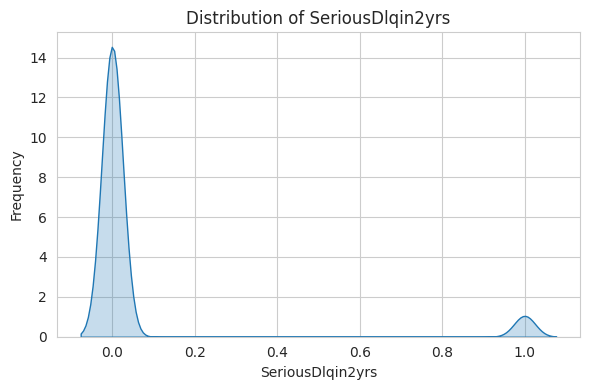

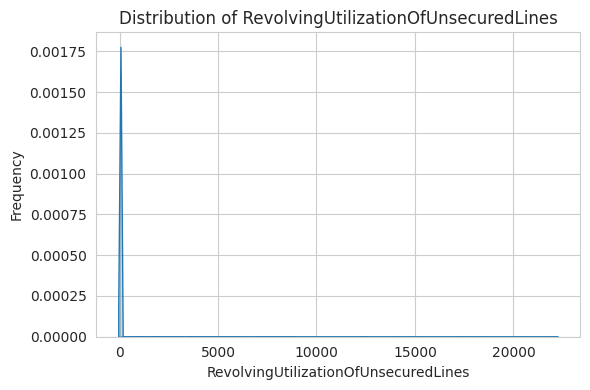

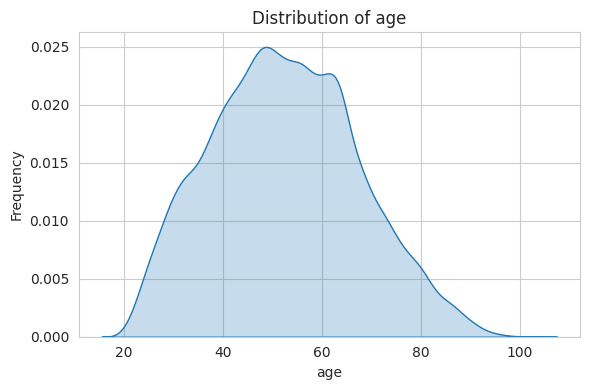

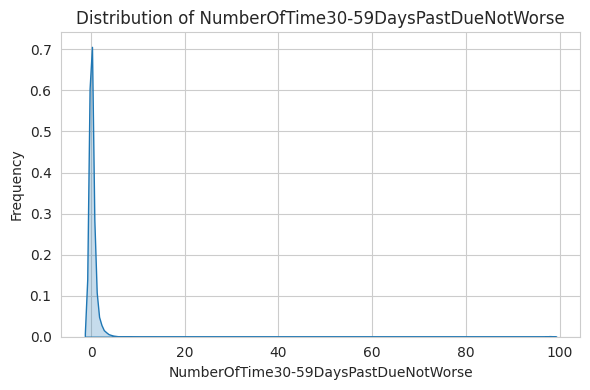

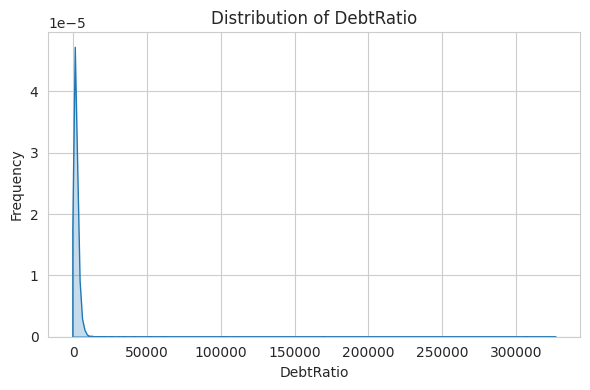

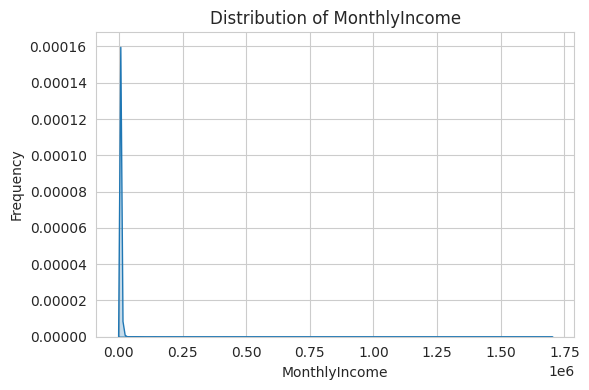

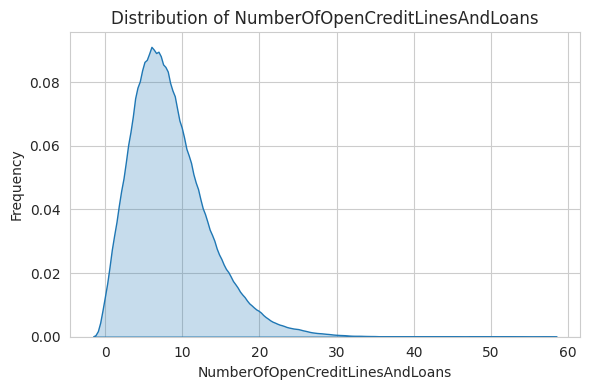

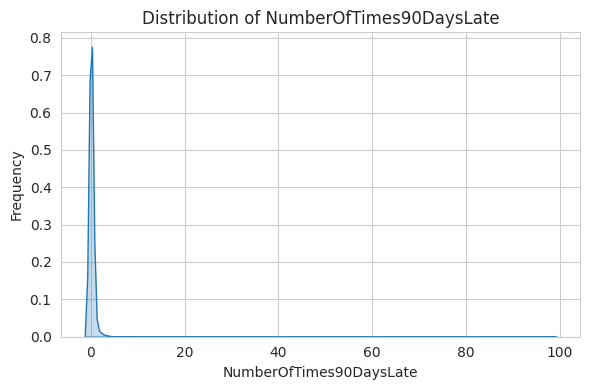

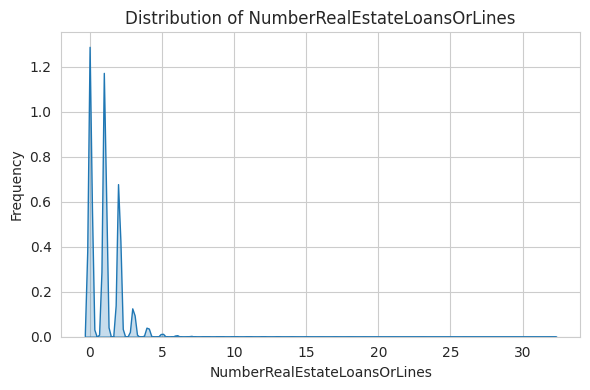

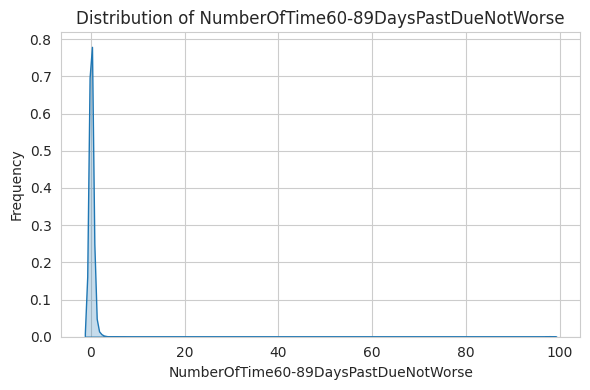

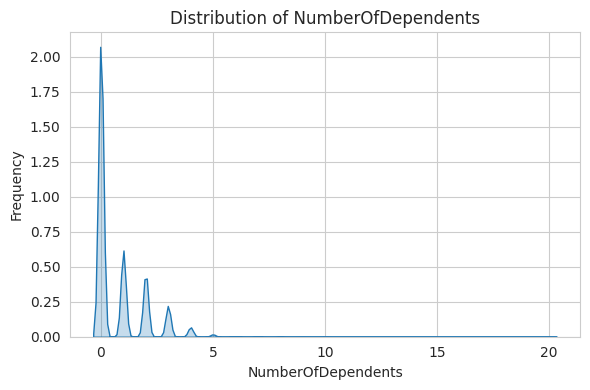

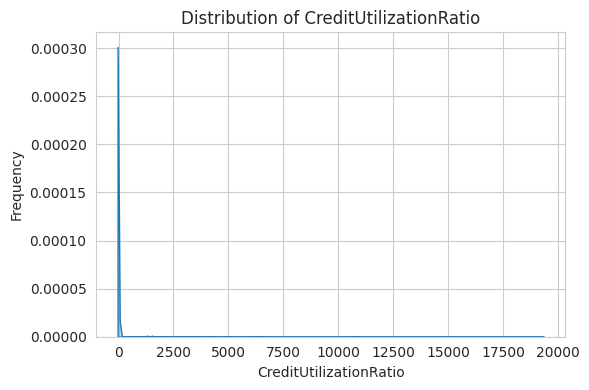

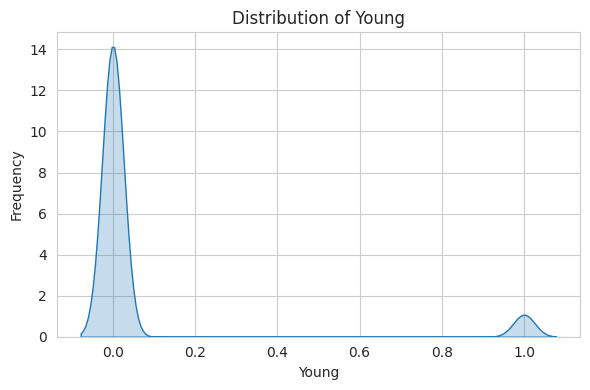

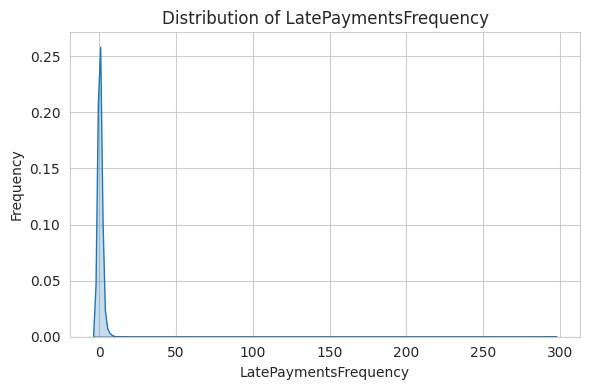

In [218]:
numerical_columns = df_train.select_dtypes(include=['number']).columns

#get distribution plots for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df_train, x=col, fill=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

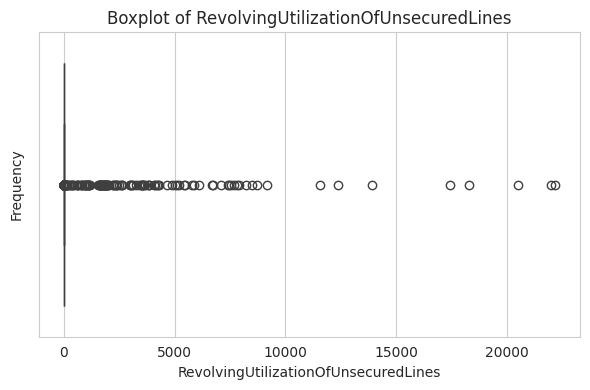

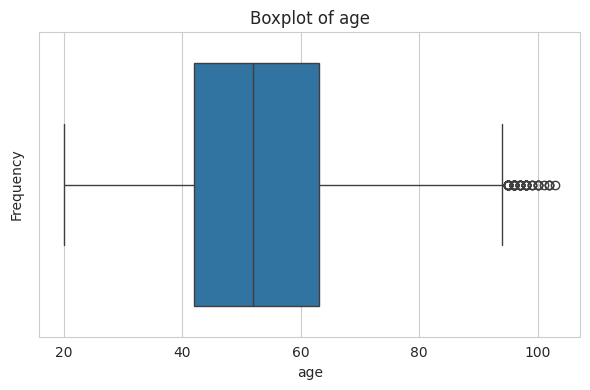

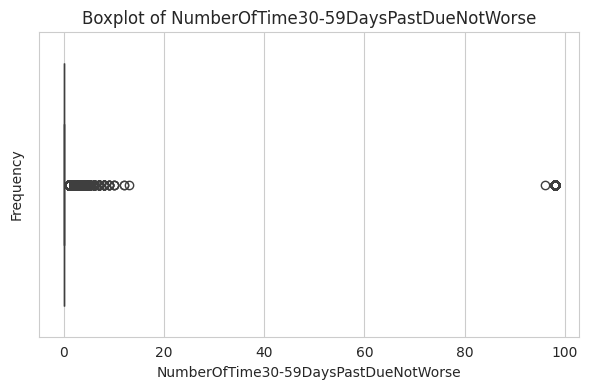

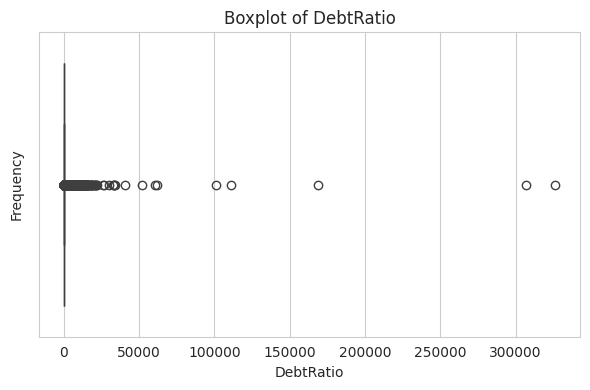

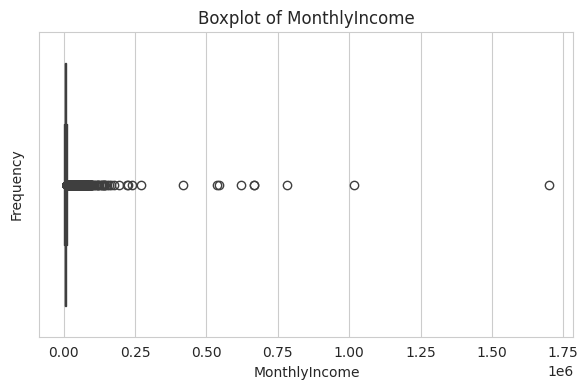

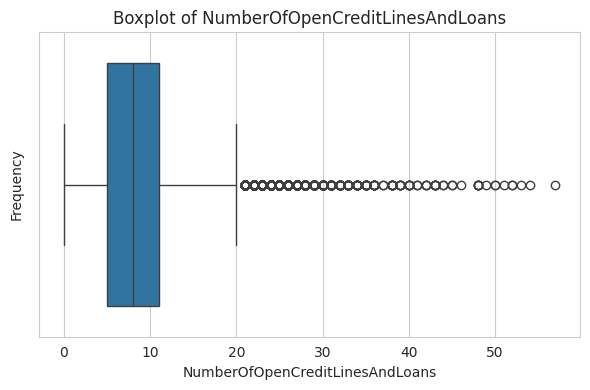

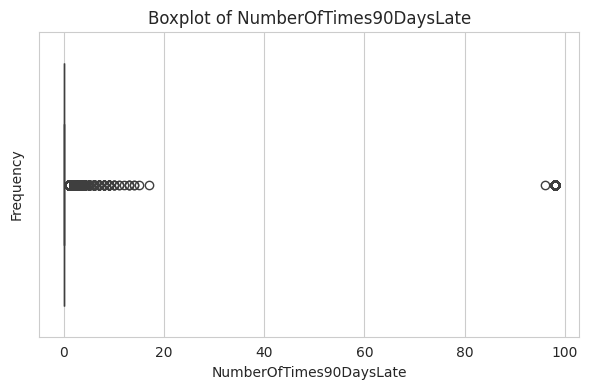

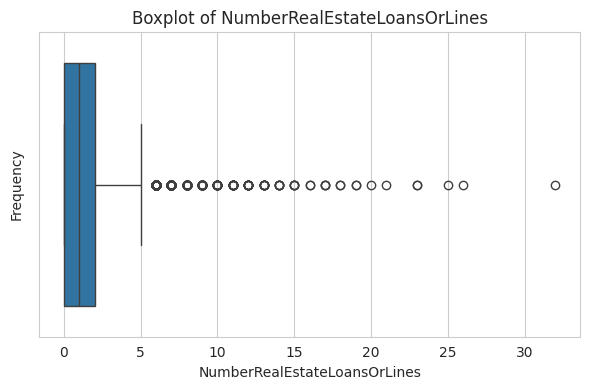

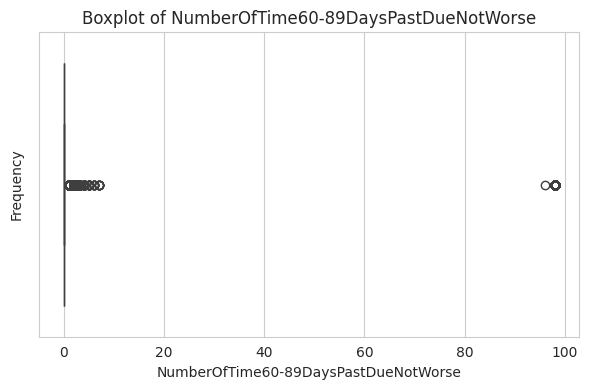

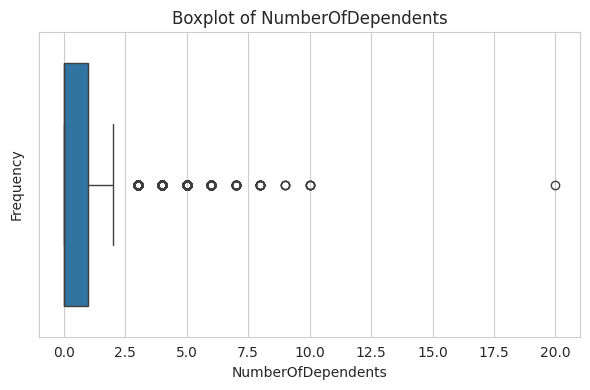

In [219]:
numerical_columns = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

#get boxplots for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_train, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

### Target variable SeriousDlqin2yrs - Unbalanced

Target variable. Person experienced 90 days past due delinquency or worse. (Y/N)

In [220]:
df_train['SeriousDlqin2yrs'].describe()

count    90000.000000
mean         0.067178
std          0.250331
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: SeriousDlqin2yrs, dtype: float64

In [221]:
value_count= df_train['SeriousDlqin2yrs'].value_counts()
value_count

SeriousDlqin2yrs
0.0    83954
1.0     6046
Name: count, dtype: int64

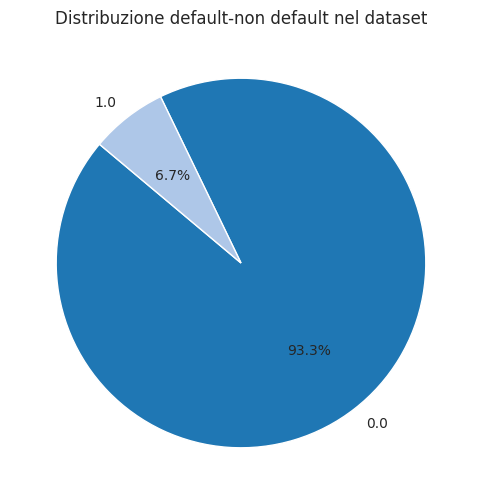

In [222]:
plt.figure(figsize=(8, 6))
colors = ['#1F77B4', '#AEC7E8']
plt.pie(value_count, labels=value_count.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribuzione default-non default nel dataset')
plt.show()

Very unbalanced dataset. It is going to be a problem, since models may favor the majority class, leading to poor performance in predicting the minority class. Furthermore for us it is much more important to correctly predict the 1s rather than the 0s.

### RevolvingUtilizationOfUnsecuredLines - dropped outliers above .995 percentile

Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits (percentage).
It's a percentage. There are some unusually high values.
The 'RevolvingUtilizationOfUnsecuredLines' variable has a wide range of values, with a mean of approximately 5.53. This suggests that, on average, borrowers have a high utilization of unsecured lines of credit relative to their credit limits.

In [223]:
df_train_original['RevolvingUtilizationOfUnsecuredLines'].describe()

count    90000.000000
mean         5.537315
std        212.215690
min          0.000000
25%          0.029613
50%          0.153270
75%          0.557429
max      22198.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [224]:
quantiles = [0.80, 0.85, 0.90, 0.95, 0.975, 0.99, 0.995]
for q in quantiles:
    print(f"{q*100}% quantile:", df_train_original['RevolvingUtilizationOfUnsecuredLines'].quantile(q))

80.0% quantile: 0.6976066899999999
85.0% quantile: 0.8538218933999999
90.0% quantile: 0.9825975959000005
95.0% quantile: 0.9999999
97.5% quantile: 0.9999999
99.0% quantile: 1.0958093401299995
99.5% quantile: 1.3681787300550003


The observation that, up to the 99.5th quantile, all values remain below 1.3, with a mean close to 5.537315, can be attributed solely to the existence of a small number of exceptionally large values in the dataset, beyond the 99.5th quantile. This is evidenced by the presence of extremely large values, with the maximum reaching 22198.

In [225]:
q_995 = df_train_original['RevolvingUtilizationOfUnsecuredLines'].quantile(0.995)
dataset = df_train_original[df_train_original['RevolvingUtilizationOfUnsecuredLines'] > q_995]
dataset['RevolvingUtilizationOfUnsecuredLines'].describe()


count      450.000000
mean      1044.449301
std       2817.775282
min          1.368260
25%          1.540721
50%          1.918552
75%        459.750000
max      22198.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

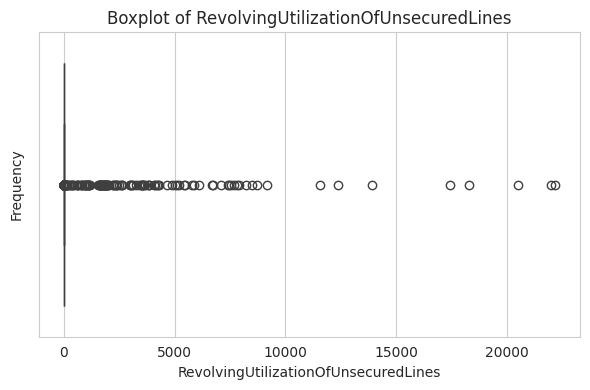

In [226]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_train_original, x='RevolvingUtilizationOfUnsecuredLines')
plt.title(f'Boxplot of {"RevolvingUtilizationOfUnsecuredLines"}')
plt.xlabel('RevolvingUtilizationOfUnsecuredLines')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The boxplot confirms our previous prediction about the presence of very few, very extreme outliers. These outliers could pose a threat to our models. Furthermore we do not know how the data was collected, so we do not discard the possibility of some errors in the data. Thus we are going to drop very extreme outliers to avoid that they could influence too much our results.

In [227]:
q_995 = df_train_original['RevolvingUtilizationOfUnsecuredLines'].quantile(0.995)

data_1_to_drop = df_train_original[df_train_original['RevolvingUtilizationOfUnsecuredLines'] > q_995]

len(data_1_to_drop)

450

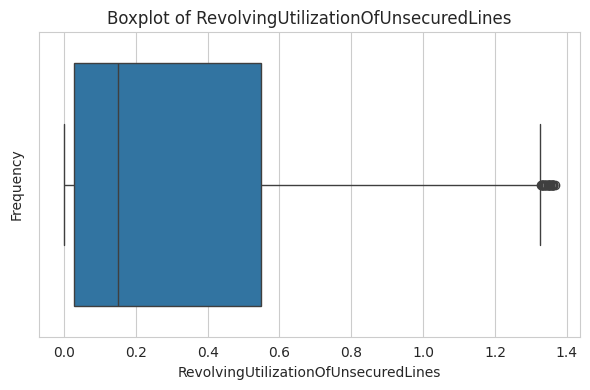

In [228]:
temporary = df_train_original[df_train_original['RevolvingUtilizationOfUnsecuredLines'] <= q_995]

plt.figure(figsize=(6, 4))
sns.boxplot(data=temporary, x='RevolvingUtilizationOfUnsecuredLines')
plt.title(f'Boxplot of {"RevolvingUtilizationOfUnsecuredLines"}')
plt.xlabel('RevolvingUtilizationOfUnsecuredLines')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Age - no operation performed

Age of borrower in years (integer)

In [229]:
df_train_original['age'].describe()

count    90000.00000
mean        52.48720
std         14.81059
min         20.00000
25%         42.00000
50%         52.00000
75%         63.00000
max        103.00000
Name: age, dtype: float64

<Axes: xlabel='age', ylabel='Density'>

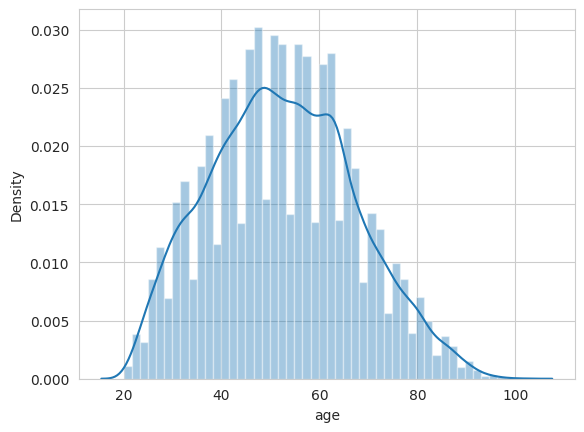

In [230]:
sns.distplot(df_train_original['age'])

In [231]:
quantiles = [0.001, 0.005, 0.01, 0.02,0.05, 0.1, 0.90, 0.95, 0.975, 0.99, 0.995, 0.999]
for q in quantiles:
    print(f"{q*100}% quantile:", df_train_original['age'].quantile(q))

0.1% quantile: 21.0
0.5% quantile: 23.0
1.0% quantile: 24.0
2.0% quantile: 25.0
5.0% quantile: 29.0
10.0% quantile: 33.0
90.0% quantile: 72.0
95.0% quantile: 78.0
97.5% quantile: 82.0
99.0% quantile: 87.0
99.5% quantile: 90.0
99.9% quantile: 94.0


It seems that the "Age" variable tends to follow a Normal distribution. We do not see any relevant problem in how the "age" values are distributed, thus we are not going to do any operation on the data.

### NumberOfTime30-59DaysPastDueNotWorse - dropped all the outliers above 13

Number of times borrower has been 30-59 days past due but no worse in the last 2 years (integer).

In [232]:
df_train_original['NumberOfTime30-59DaysPastDueNotWorse'].describe()

count    90000.000000
mean         0.428622
std          4.288501
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         98.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64

<Axes: xlabel='NumberOfTime30-59DaysPastDueNotWorse', ylabel='Density'>

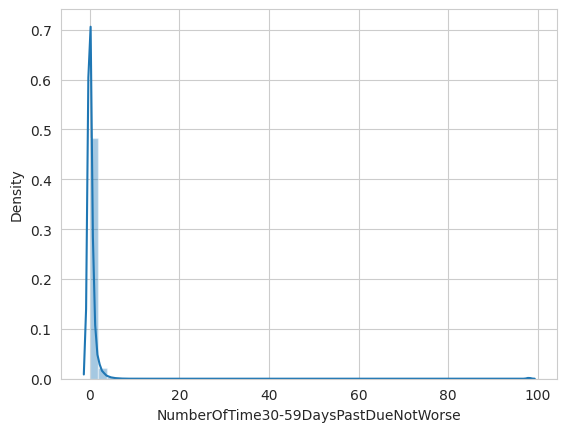

In [233]:
sns.distplot(df_train_original['NumberOfTime30-59DaysPastDueNotWorse'])

In [234]:
quantiles = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.90, 0.95, 0.975, 0.99, 0.995, 0.999]
for q in quantiles:
    print(f"{q*100}% quantile:", df_train_original['NumberOfTime30-59DaysPastDueNotWorse'].quantile(q))

0.1% quantile: 0.0
0.5% quantile: 0.0
1.0% quantile: 0.0
2.0% quantile: 0.0
5.0% quantile: 0.0
10.0% quantile: 0.0
90.0% quantile: 1.0
95.0% quantile: 2.0
97.5% quantile: 2.0
99.0% quantile: 4.0
99.5% quantile: 5.0
99.9% quantile: 98.0


In [235]:
df_train_original[(df_train_original['NumberOfTime30-59DaysPastDueNotWorse']>13) & (df_train_original['NumberOfTime30-59DaysPastDueNotWorse']<96)].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,CreditUtilizationRatio,Young,LatePaymentsFrequency
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most of the data are concentrated around zero, as we can see 90% of the observations are less than 1. However, this variable shows a very strange behavior, although most of the data are near zero, there are some extreme outliers with values above 90. In addition, a curious feature of this variable is that there are no observations between 13 and 96 (excluded). This makes us think that perhaps the values above 90 are errors. For this reason and also because leaving them could lead to error in our models, we will eliminate outliers above 13.

In [236]:
data_2_to_drop = df_train_original[df_train_original['NumberOfTime30-59DaysPastDueNotWorse'] > 13]
len(data_2_to_drop)

169

<Axes: xlabel='NumberOfTime30-59DaysPastDueNotWorse', ylabel='Density'>

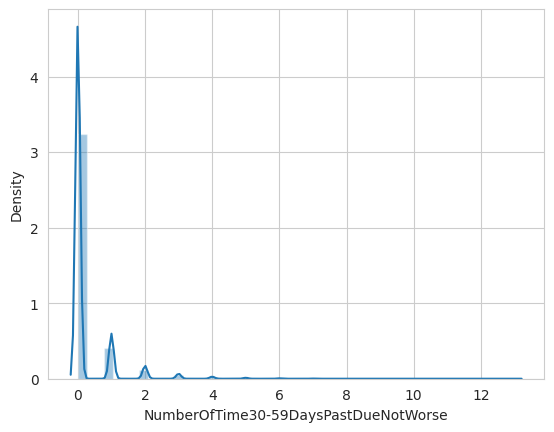

In [237]:
temporary = df_train_original[df_train_original['NumberOfTime30-59DaysPastDueNotWorse'] <= 13]

sns.distplot(temporary['NumberOfTime30-59DaysPastDueNotWorse'])


### DebtRatio - dropped outliers above .995 percentile

Monthly debt payments, alimony, living costs divided by monthly gross income(percentage)

In [238]:
df_train_original["DebtRatio"].describe()

count     90000.000000
mean        349.659309
std        2025.324198
min           0.000000
25%           0.174752
50%           0.365609
75%           0.852903
max      326442.000000
Name: DebtRatio, dtype: float64

<Axes: xlabel='DebtRatio', ylabel='Density'>

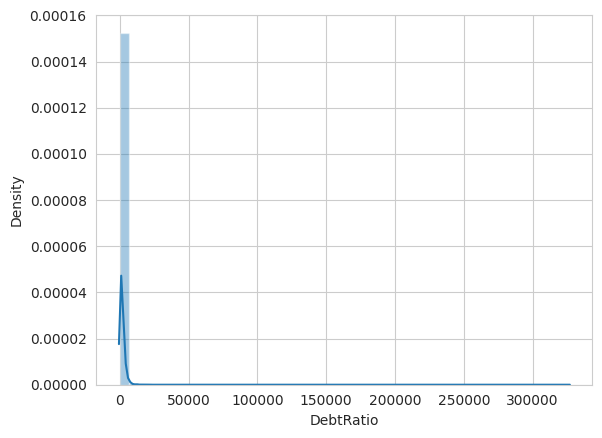

In [239]:
sns.distplot(df_train_original['DebtRatio'])

In [240]:
quantiles = [0.75,0.8,0.85,0.9,0.95,0.975,0.99, 0.995]

for i in quantiles:
    print(i*100,'% quantile of debt ratio is: ',df_train_original.DebtRatio.quantile(i))

75.0 % quantile of debt ratio is:  0.8529031982499999
80.0 % quantile of debt ratio is:  3.2332572009999954
85.0 % quantile of debt ratio is:  256.0
90.0 % quantile of debt ratio is:  1264.0
95.0 % quantile of debt ratio is:  2423.0
97.5 % quantile of debt ratio is:  3472.0
99.0 % quantile of debt ratio is:  4946.009999999995
99.5 % quantile of debt ratio is:  6164.010000000009


Most of the observations are very small, 80% of the observation are below 1. However there are some extreme outliers and this lead the mean towards 350.56. We believe that in a variable like this, is possible to have values of the dimension of 10^3, however values like 326442 seems really implausible. For this reason and also because they could be a problem in the training of our models, we are going to drop all the data above the .995 percentile.

In [241]:
df_train_original[df_train_original["DebtRatio"]>6178.500000000029].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,CreditUtilizationRatio,Young,LatePaymentsFrequency
count,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.00000,447.000000,447.000000,447.000000
mean,0.071588,0.363638,55.769575,0.360179,11607.563758,4837.967195,13.653244,0.035794,3.427293,0.049217,0.47651,0.000045,0.006711,0.445190
std,0.258094,0.346836,10.157644,0.866687,23507.981526,1153.678206,5.921999,0.265452,2.542635,0.236365,0.96984,0.000046,0.081739,1.048603
min,0.000000,0.000000,27.000000,0.000000,6183.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.047313,48.000000,0.000000,6788.000000,5112.461788,9.000000,0.000000,2.000000,0.000000,0.00000,0.000005,0.000000,0.000000
50%,0.000000,0.244558,56.000000,0.000000,7793.000000,5112.461788,13.000000,0.000000,3.000000,0.000000,0.00000,0.000028,0.000000,0.000000
75%,0.000000,0.646089,63.000000,0.000000,9758.000000,5112.461788,17.000000,0.000000,4.000000,0.000000,0.00000,0.000077,0.000000,0.000000
max,1.000000,1.313807,88.000000,6.000000,326442.000000,5112.461788,33.000000,4.000000,23.000000,2.000000,5.00000,0.000172,1.000000,7.000000


In [242]:
q_995 = df_train_original.DebtRatio.quantile(0.995)
data_3_to_drop = df_train_original[df_train_original["DebtRatio"] > q_995]
len(data_3_to_drop)

450

### MonthlyIncome - drop all the data above the 0.99 percentile.

Monthly income (real)

In [243]:
df_train_original["MonthlyIncome"].describe()

count    9.000000e+04
mean     6.070250e+03
std      1.000930e+04
min      0.000000e+00
25%      3.703799e+03
50%      5.112462e+03
75%      7.005881e+03
max      1.700580e+06
Name: MonthlyIncome, dtype: float64

In [244]:
quantiles = [0.75,0.8,0.81,0.85,0.9,0.95,0.975,0.99]

for i in quantiles:
    print(i*100,'% quantile of debt ratio is: ',df_train_original.MonthlyIncome.quantile(i))

75.0 % quantile of debt ratio is:  7005.881058907136
80.0 % quantile of debt ratio is:  7815.459160587995
81.0 % quantile of debt ratio is:  7992.923814738277
85.0 % quantile of debt ratio is:  8893.37273388698
90.0 % quantile of debt ratio is:  10217.403763698328
95.0 % quantile of debt ratio is:  12868.420045955174
97.5 % quantile of debt ratio is:  16100.672447290552
99.0 % quantile of debt ratio is:  21843.383546117013


Overall the behaviour of this variable is not so strange, However there are few very extreme outliers that could pose a threath to our models. To avoid this danger, we are going to drop all the data above the 0.99 percentile.

In [245]:
quantile_99 = df_train_original.MonthlyIncome.quantile(0.99)
data_4_to_drop = df_train_original[df_train_original['MonthlyIncome'] > quantile_99]
len(data_4_to_drop)

900

<Axes: xlabel='MonthlyIncome', ylabel='Density'>

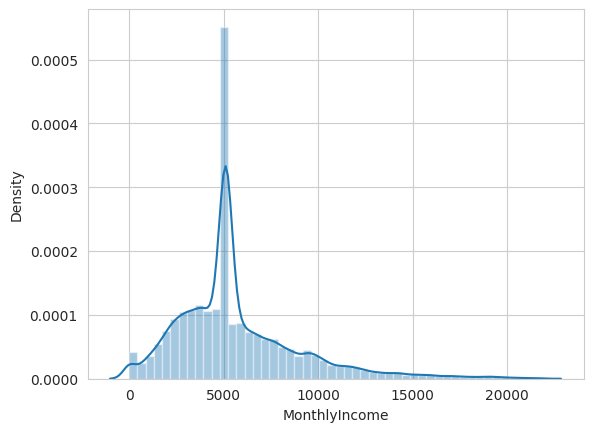

In [246]:
temporary = df_train_original[df_train_original['MonthlyIncome'] <= quantile_99]
sns.distplot(temporary['MonthlyIncome'])

### NumberOfOpenCreditLinesAndLoans - no operation performed

Number of open loans (installment like car loan or
mortgage) and lines of credit (e.g. credit cards) (integer)

In [247]:
df_train_original["NumberOfOpenCreditLinesAndLoans"].describe()

count    90000.000000
mean         8.448267
std          5.138979
min          0.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         57.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

<Axes: xlabel='NumberOfOpenCreditLinesAndLoans', ylabel='Density'>

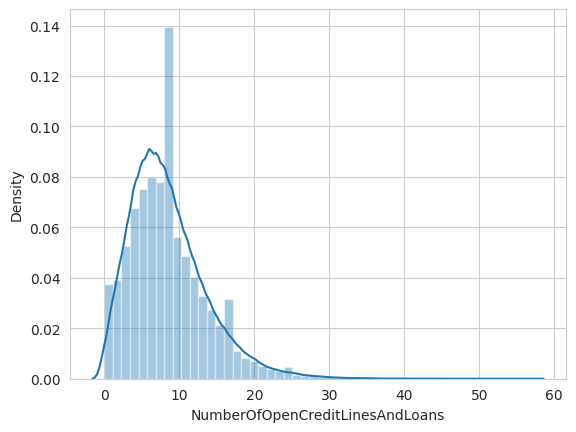

In [248]:
sns.distplot(df_train_original['NumberOfOpenCreditLinesAndLoans'])

The behaviour of this variable does not seem very strange. It seems to follow a right skewed distribution with some outliers with values around 50. However these outliers do not seeem to be very extreme as in the other variables, for this reason we are not going to perform any operation on this variable.

### NumberOfTimes90DaysLate - dropped all data above 17

 Number of times borrower has been 90 days or more past due
(integer)

In [249]:
df_train_original['NumberOfTimes90DaysLate'].describe()

count    90000.000000
mean         0.275867
std          4.266504
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         98.000000
Name: NumberOfTimes90DaysLate, dtype: float64

In [250]:
quantiles = [0.75,0.8,0.81,0.85,0.9,0.95,0.975,0.99]

for i in quantiles:
    print(i*100,'% quantile of debt ratio is: ',df_train_original.NumberOfTimes90DaysLate.quantile(i))

75.0 % quantile of debt ratio is:  0.0
80.0 % quantile of debt ratio is:  0.0
81.0 % quantile of debt ratio is:  0.0
85.0 % quantile of debt ratio is:  0.0
90.0 % quantile of debt ratio is:  0.0
95.0 % quantile of debt ratio is:  1.0
97.5 % quantile of debt ratio is:  1.0
99.0 % quantile of debt ratio is:  3.0


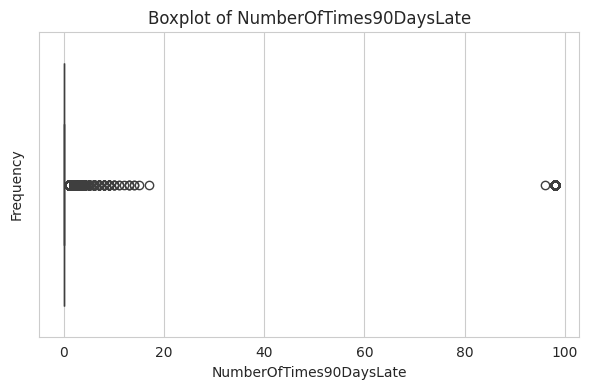

In [251]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_train_original, x='NumberOfTimes90DaysLate')
plt.title(f'Boxplot of {"NumberOfTimes90DaysLate"}')
plt.xlabel('NumberOfTimes90DaysLate')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

99% of the data are below 3. However, as we can also see from the boxplot, there are some extreme outliers.

In [252]:
df_train_original[(df_train_original["NumberOfTimes90DaysLate"]>17) & (df_train_original["NumberOfTimes90DaysLate"]<96)].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,CreditUtilizationRatio,Young,LatePaymentsFrequency
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Very strange behaviour. No data between 17 and 98. The data above 17 are very few and all extreme outliers; we are going to drop them.

In [253]:
data_5_to_drop = df_train_original[df_train_original["NumberOfTimes90DaysLate"] > 17]
len(data_5_to_drop)

169

### NumberRealEstateLoansOrLines - dropped all data above .999 quantile

In [254]:
df_train_original['NumberRealEstateLoansOrLines'].describe()

count    90000.000000
mean         1.017867
std          1.124537
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         32.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

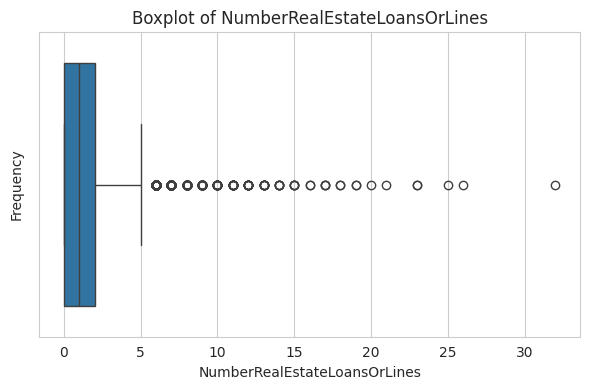

In [255]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_train_original, x='NumberRealEstateLoansOrLines')
plt.title(f'Boxplot of {"NumberRealEstateLoansOrLines"}')
plt.xlabel("NumberRealEstateLoansOrLines")
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

(array([8.7815e+04, 1.9010e+03, 2.0000e+02, 5.1000e+01, 1.7000e+01,
        9.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 0. ,  3.2,  6.4,  9.6, 12.8, 16. , 19.2, 22.4, 25.6, 28.8, 32. ]),
 <BarContainer object of 10 artists>)

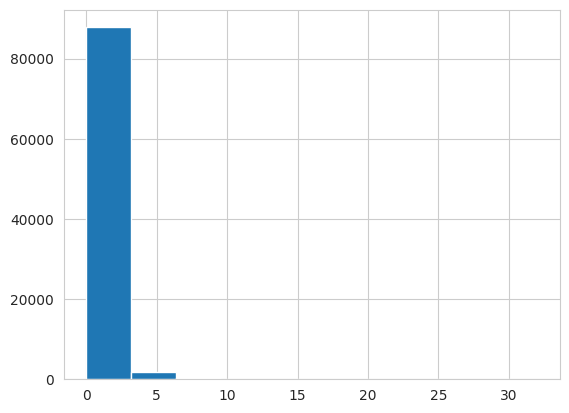

In [256]:
plt.hist(df_train_original["NumberRealEstateLoansOrLines"])

In [257]:
quantiles = [0.75,0.8,0.81,0.85,0.9,0.95,0.975,0.99,0.999]

for i in quantiles:
    print(i*100,'% quantile is: ',df_train_original.NumberRealEstateLoansOrLines.quantile(i))

75.0 % quantile is:  2.0
80.0 % quantile is:  2.0
81.0 % quantile is:  2.0
85.0 % quantile is:  2.0
90.0 % quantile is:  2.0
95.0 % quantile is:  3.0
97.5 % quantile is:  3.0
99.0 % quantile is:  5.0
99.9 % quantile is:  9.0


In [258]:
quantile_999 = df_train_original.NumberRealEstateLoansOrLines.quantile(0.999)
data_6_to_drop= df_train_original[df_train_original["NumberRealEstateLoansOrLines"] > quantile_999]
len(data_6_to_drop)

84

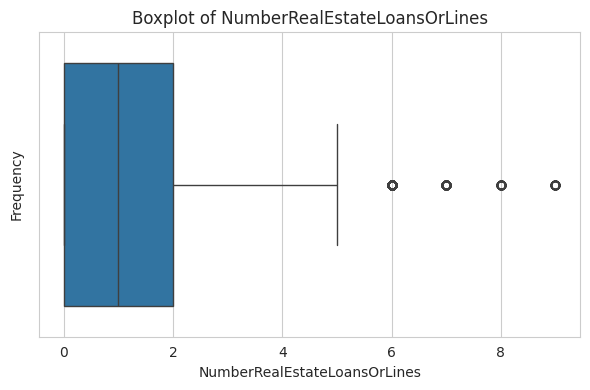

In [259]:
temporary = df_train_original[df_train_original["NumberRealEstateLoansOrLines"] <= quantile_999]

plt.figure(figsize=(6, 4))
sns.boxplot(data=temporary, x='NumberRealEstateLoansOrLines')
plt.title(f'Boxplot of {"NumberRealEstateLoansOrLines"}')
plt.xlabel("NumberRealEstateLoansOrLines")
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

(array([33687., 31447., 18950.,  3731.,  1282.,   418.,   201.,   106.,
           53.,    41.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

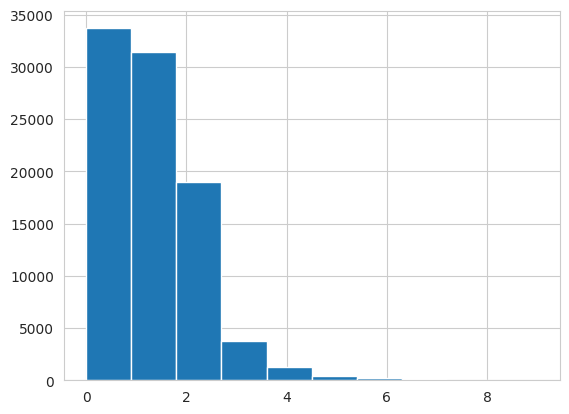

In [260]:
plt.hist(temporary["NumberRealEstateLoansOrLines"])

Most of the observation (99.9% of them) are equal or below 9. As we can see in the first boxplot there are few outliers that could be problematic, to avoid any problem we are going to drop all observation above the .999 percentile.

### NumberOfTime60-89DaysPastDueNotWorse - no operation done

In [261]:
df_train_original['NumberOfTime60-89DaysPastDueNotWorse'].describe()

count    90000.000000
mean         0.248256
std          4.251910
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64

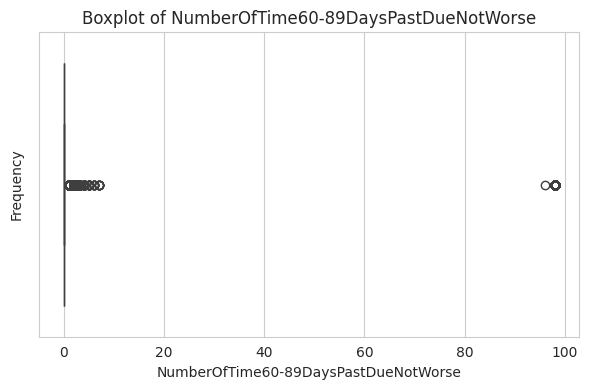

In [262]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_train_original, x='NumberOfTime60-89DaysPastDueNotWorse')
plt.title(f'Boxplot of {"NumberOfTime60-89DaysPastDueNotWorse"}')
plt.xlabel("NumberOfTime60-89DaysPastDueNotWorse")
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [263]:
quantiles = [0.75,0.8,0.81,0.85,0.9,0.95,0.975,0.99,0.999]

for i in quantiles:
    print(i*100,'% quantile is: ',df_train_original["NumberOfTime60-89DaysPastDueNotWorse"].quantile(i))

75.0 % quantile is:  0.0
80.0 % quantile is:  0.0
81.0 % quantile is:  0.0
85.0 % quantile is:  0.0
90.0 % quantile is:  0.0
95.0 % quantile is:  1.0
97.5 % quantile is:  1.0
99.0 % quantile is:  2.0
99.9 % quantile is:  98.0


Most of the data are below 2. As we can clearly see in the boxplot there are few very extreme outliers.

In [264]:
df_train_original[(df_train_original["NumberOfTime60-89DaysPastDueNotWorse"]>7) & (df_train_original["NumberOfTime60-89DaysPastDueNotWorse"]<96)].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,CreditUtilizationRatio,Young,LatePaymentsFrequency
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


No data between 7 and 96. This leap in the data is very strange. The data above 90 could even be errors. For this reason and to avoid any threats they could pose to our models, we are going to drop all data above 10.

In [265]:
data_7_to_drop = df_train_original[df_train_original["NumberOfTime60-89DaysPastDueNotWorse"] >= 10]
len(data_7_to_drop)

169

### NumberOfDependents - dropped above 10

In [266]:
df_train_original['NumberOfDependents'].describe()

count    90000.000000
mean         0.738156
std          1.108435
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         20.000000
Name: NumberOfDependents, dtype: float64

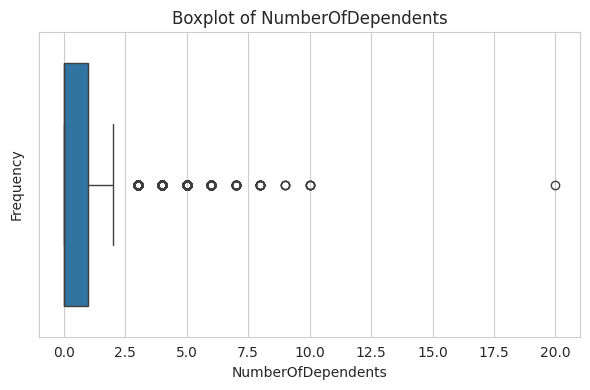

In [267]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_train_original, x='NumberOfDependents')
plt.title(f'Boxplot of {"NumberOfDependents"}')
plt.xlabel("NumberOfDependents")
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [268]:
df_train_original[df_train_original["NumberOfDependents"] > 10].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,CreditUtilizationRatio,Young,LatePaymentsFrequency
count,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0
mean,0.0,0.226616,39.0,1.0,0.576539,5963.201332,11.0,2.0,1.0,0.0,20.0,0.143743,0.0,3.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,0.226616,39.0,1.0,0.576539,5963.201332,11.0,2.0,1.0,0.0,20.0,0.143743,0.0,3.0
25%,0.0,0.226616,39.0,1.0,0.576539,5963.201332,11.0,2.0,1.0,0.0,20.0,0.143743,0.0,3.0
50%,0.0,0.226616,39.0,1.0,0.576539,5963.201332,11.0,2.0,1.0,0.0,20.0,0.143743,0.0,3.0
75%,0.0,0.226616,39.0,1.0,0.576539,5963.201332,11.0,2.0,1.0,0.0,20.0,0.143743,0.0,3.0
max,0.0,0.226616,39.0,1.0,0.576539,5963.201332,11.0,2.0,1.0,0.0,20.0,0.143743,0.0,3.0


Most of the data are below 10, only one observation above 10 and it is 20. It can be clearly seen from the boxplot. We are going to drop this outlier.

In [269]:
data_8_to_drop= df_train_original[df_train_original['NumberOfDependents'] > 10]
len(data_8_to_drop)

1

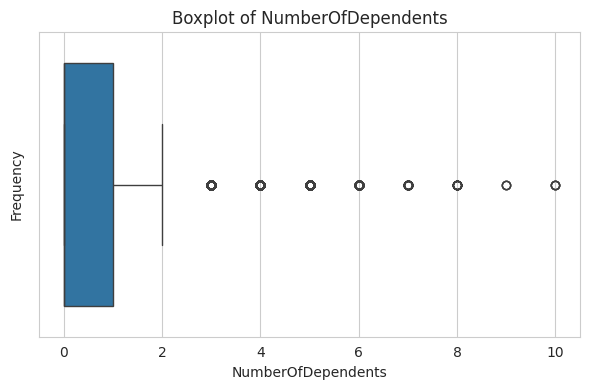

In [270]:
temporary = df_train_original[df_train_original['NumberOfDependents'] <= 10]

plt.figure(figsize=(6, 4))
sns.boxplot(data=temporary, x='NumberOfDependents')
plt.title(f'Boxplot of {"NumberOfDependents"}')
plt.xlabel("NumberOfDependents")
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Drop the outliers

In [271]:
df_train.shape

(90000, 14)

In [272]:
df_train_original.shape

(90000, 14)

In [273]:

indices_to_drop = np.unique(
    np.concatenate([
        data_1_to_drop.index,
        data_2_to_drop.index,
        data_3_to_drop.index,
        data_4_to_drop.index,
        data_5_to_drop.index,
        data_6_to_drop.index,
        data_7_to_drop.index,
        data_8_to_drop.index
    ])
)

df_train = df_train.drop(indices_to_drop)


In [274]:
df_train.shape

(87976, 14)

## *Bivariate analysis* - Relationship with target variable

Now that our dataset is free of any abnormal values and outliers, I will perform a bivariate analysis to see what is the relationship between each of the predictors variables and the target variable - Default.

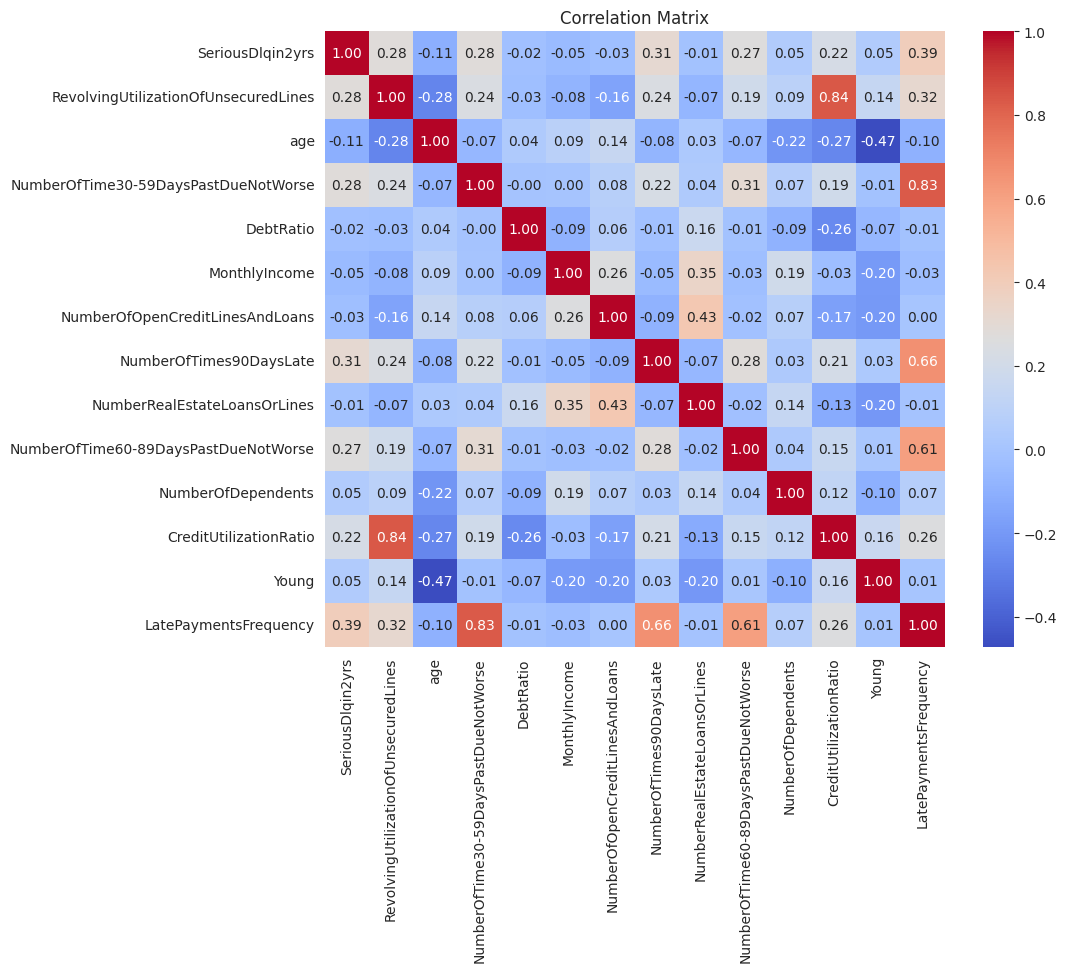

In [275]:
correlation_matrix = df_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Baseline model

From now on the results of the metrics will be stored in the following lists

In [276]:
X_train = df_train.drop(columns=["SeriousDlqin2yrs"])  #Drop "SeriousDlqin2yrs"
y_train = df_train["SeriousDlqin2yrs"]  #Select only "SeriousDlqin2yrs" for Y_train

In [277]:
accuracies = {}
recalls = {}
f1s = {}
aucs = {}

In [278]:
model = LogisticRegression(random_state=42)
modelname = "LogisticRegression*"
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob_baseline =model.predict_proba(X_test)[:, 1]

recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob_baseline)

accuracies[modelname] = model.score(X_test, y_test)
recalls[modelname] = recall
f1s[modelname] = f1
aucs[modelname] = roc_auc

print("Accuracy", accuracies)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC Score:", roc_auc)


Accuracy {'LogisticRegression*': 0.9350666666666667}
Recall: 0.18113975576662145
F1-score: 0.26766917293233083
ROC-AUC Score: 0.807738925935338


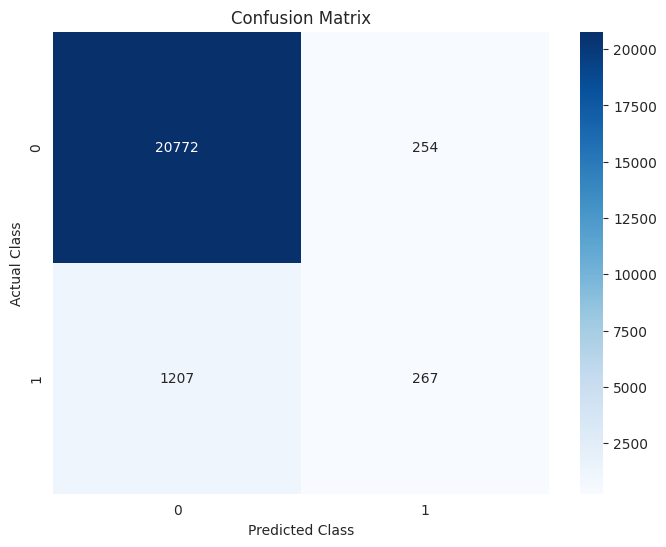

In [279]:
#compute the confusion matrix and plot it
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.show()

# Vanilla ensemble models

Let's try with ensemble with default arguments

In [280]:
#RUN TIME DISCLAIMER: 40 SECONDS
classifiers = {
    "Bagging Decision Tree": BaggingClassifier(random_state=42),
    "Boosted Decision Tree": AdaBoostClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

#Loop over the classifiers
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_prob=clf.predict_proba(X_test)[:, 1]

    #compute the metrics and store them
    accuracy = clf.score(X_test, y_test)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    accuracies[name] = clf.score(X_test, y_test)
    recalls[name] = recall
    f1s[name] = f1
    aucs[name] = auc

    results[name] = {"accuracy": accuracy, "recall": recall, "f1": f1, "auc": auc}

#print the metrics
print("{:<25} {:<10} {:<10} {:<10} {:<10}".format("Classifier", "Accuracy", "Recall", "F1-score", "AUC"))
print("-" * 70)
for name, scores in results.items():
    print("{:<25} {:.4f}     {:.4f}     {:.4f}     {:.4f}".format(name, scores["accuracy"], scores["recall"], scores["f1"], scores["auc"]))

Classifier                Accuracy   Recall     F1-score   AUC       
----------------------------------------------------------------------
Bagging Decision Tree     0.9318     0.1852     0.2624     0.7657
Boosted Decision Tree     0.9360     0.2347     0.3246     0.8540
Random Forest             0.9348     0.1920     0.2783     0.8343


There is a problem in their performances, they should perform better than the baseline, especially for the recall. There is probably a problem of overfitting, let's compute the training and testing metrics to understand what's going on

In [281]:
#RUN TIME DISCLAIMER: 40 SECONDS
classifiers = {
    "Bagging Decision Tree": BaggingClassifier(random_state=42),
    "Boosted Decision Tree": AdaBoostClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

#Loop over the classifiers
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    #store prediction on train and test set
    y_train_pred = clf.predict(X_train)
    y_train_pred_prob = clf.predict_proba(X_train)[:, 1]
    y_test_pred = clf.predict(X_test)
    y_test_pred_prob = clf.predict_proba(X_test)[:, 1]

    #compute the metrics on both the test and train set
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)

    results[name] = {
        "train_recall": train_recall, "train_f1": train_f1, "train_auc": train_auc,
        "test_recall": test_recall, "test_f1": test_f1, "test_auc": test_auc
    }

#print the results
print("{:<25} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format("Classifier",
      "Train_Recall", "Train_F1", "Train_AUC", "Test_Recall", "Test_F1", "Test_AUC"))
print("-" * 95)
for name, scores in results.items():
    print("{:<25} {:.4f}     {:.4f}     {:.4f}     {:.4f}     {:.4f}     {:.4f}".format(
        name, scores["train_recall"], scores["train_f1"], scores["train_auc"],
        scores["test_recall"], scores["test_f1"], scores["test_auc"]))

Classifier                Train_Recall Train_F1   Train_AUC  Test_Recall Test_F1    Test_AUC  
-----------------------------------------------------------------------------------------------
Bagging Decision Tree     0.8682     0.9272     0.9996     0.1852     0.2624     0.7657
Boosted Decision Tree     0.2151     0.3114     0.8620     0.2347     0.3246     0.8540
Random Forest             0.9970     0.9982     1.0000     0.1920     0.2783     0.8343


Yes, it seems to be that there is an overfitting problem. To reduce the variance we try to increase ne number of estimators for the RF and Bagging from 10 (default) to 50, and increase the minimum number of samples required to split an internal node of the Tree classifiers of the Adaboost (from 1 to 5). In this way the overfitting should decrease leaving more space for higher performances in the test set. Computational time of course increases.

In [282]:
#RUN TIME DISCLAIMER: 1 MINUTE
classifiers = {
    "Bagging Decision Tree": BaggingClassifier(n_estimators=50,random_state=42),
    "Boosted Decision Tree": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,min_samples_split=5),random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50,random_state=42)
}

#loop over the classifier
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    #store prediction on train and test set
    y_train_pred = clf.predict(X_train)
    y_train_pred_prob = clf.predict_proba(X_train)[:, 1]
    y_test_pred = clf.predict(X_test)
    y_test_pred_prob = clf.predict_proba(X_test)[:, 1]

    #compute the metrics on both the test and train set
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_pred_prob)

    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    accuracy = clf.score(X_test, y_test)

    #Record results
    accuracies[name] = accuracy
    recalls[name] = test_recall
    f1s[name] = test_f1
    aucs[name] = test_auc

    results[name] = {
        "train_recall": train_recall, "train_f1": train_f1, "train_auc": train_auc,
        "test_recall": test_recall, "test_f1": test_f1, "test_auc": test_auc
    }

#print the results
print("{:<25} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format("Classifier",
      "Train_Recall", "Train_F1", "Train_AUC", "Test_Recall", "Test_F1", "Test_AUC"))
print("-" * 95)
for name, scores in results.items():
    print("{:<25} {:.4f}     {:.4f}     {:.4f}     {:.4f}     {:.4f}     {:.4f}".format(
        name, scores["train_recall"], scores["train_f1"], scores["train_auc"],
        scores["test_recall"], scores["test_f1"], scores["test_auc"]))

Classifier                Train_Recall Train_F1   Train_AUC  Test_Recall Test_F1    Test_AUC  
-----------------------------------------------------------------------------------------------
Bagging Decision Tree     0.9909     0.9951     1.0000     0.1866     0.2654     0.8171
Boosted Decision Tree     0.2151     0.3114     0.8620     0.2347     0.3246     0.8540
Random Forest             0.9909     0.9952     1.0000     0.1839     0.2674     0.8242


# Solutions to unbalance data

We can see that the overfitting is alliviated, but recall is still very low still because of the unbalancedness of our dataset. Being the positive value our crucial target, let's try to solve this problem in three possible ways (maintaining the same parameters of the previous models).


1.   Data Resampling (ROS, RUS, SMOTE)
2.   Cost-sensitive learning
3.   Algorithm-level resampling

At the very end instead we explore a specific combination proved successful in a paper that we read (ROS+Adaboost, SMOTE+RF)



## 1) Data Resampling

### Random undersampling

In [283]:
#Resample with RUS
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

classifiers = {
    "RUS + Bagging Decision Tree": BaggingClassifier(random_state=42),
    "RUS + Boosted Decision Tree": AdaBoostClassifier(random_state=42),
    "RUS + Random Forest": RandomForestClassifier(random_state=42)
}

#loop over the classifier
results = {}
for name, clf in classifiers.items():
    clf.fit(X_resampled, y_resampled)
    y_pred = clf.predict(X_test)
    y_pred_prob=clf.predict_proba(X_test)[:, 1]

    #compute the metrics and store them
    accuracy = clf.score(X_test, y_test)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    accuracies[name] = accuracy
    recalls[name] = recall
    f1s[name] = f1
    aucs[name] = auc

    results[name] = {"accuracy": accuracy, "recall": recall, "f1": f1, "auc": auc}

#print the results
print("{:<25} {:<10} {:<10} {:<10} {:<10}".format("Classifier", "Accuracy", "Recall", "F1-score", "AUC"))
print("-" * 65)
for name, scores in results.items():
    print("{:<25} {:.4f}     {:.4f}     {:.4f}     {:.4f}".format(name, scores["accuracy"], scores["recall"], scores["f1"], scores["auc"]))

Classifier                Accuracy   Recall     F1-score   AUC       
-----------------------------------------------------------------
RUS + Bagging Decision Tree 0.7837     0.6906     0.2950     0.8177
RUS + Boosted Decision Tree 0.7952     0.7578     0.3265     0.8564
RUS + Random Forest       0.7829     0.7639     0.3156     0.8472


### Random Oversampling

In [284]:
#RUN TIME DISCLAIMER: 1 MINUTE
#resample with ROS
ros = RandomOverSampler(sampling_strategy='auto',random_state=420)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

classifiers = {
    "ROS + Bagging Decision Tree": BaggingClassifier(random_state=42),
    "ROS + Boosted Decision Tree": AdaBoostClassifier(random_state=42),
    "ROS + Random Forest": RandomForestClassifier()
}

#loop over the classifier
results = {}
for name, clf in classifiers.items():
    clf.fit(X_resampled, y_resampled)
    y_pred = clf.predict(X_test)
    y_pred_prob=clf.predict_proba(X_test)[:, 1]

    #compute the metrics and store them
    accuracy = clf.score(X_test, y_test)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    accuracies[name] = accuracy
    recalls[name] = recall
    f1s[name] = f1
    aucs[name] = auc

    results[name] = {"accuracy": accuracy, "recall": recall, "f1": f1, "auc": auc}

#print the results
print("{:<25} {:<10} {:<10} {:<10} {:<10}".format("Classifier", "Accuracy", "Recall", "F1-score", "AUC"))
print("-" * 65)
for name, scores in results.items():
    print("{:<25} {:.4f}     {:.4f}     {:.4f}     {:.4f}".format(name, scores["accuracy"], scores["recall"], scores["f1"], scores["auc"]))

Classifier                Accuracy   Recall     F1-score   AUC       
-----------------------------------------------------------------
ROS + Bagging Decision Tree 0.9240     0.2191     0.2743     0.7720
ROS + Boosted Decision Tree 0.8026     0.7469     0.3314     0.8546
ROS + Random Forest       0.9303     0.2415     0.3123     0.8250


### SMOTE Oversampling

In [285]:
#RUN TIME DISCLAIMER: 40 SECONDS
#resample with SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

classifiers = {
    "SMOTE + Bagging Decision Tree": BaggingClassifier(random_state=42),
    "SMOTE + Boosted Decision Tree": AdaBoostClassifier(random_state=42),
    "SMOTE + Random Forest": RandomForestClassifier(random_state=42)
}

#loop over the classifiers
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_prob=clf.predict_proba(X_test)[:, 1]

    #compute the metrics and store them
    accuracy = clf.score(X_test, y_test)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    accuracies[name] = clf.score(X_test, y_test)
    recalls[name] = recall
    f1s[name] = f1
    aucs[name] = auc

    results[name] = {"accuracy": accuracy, "recall": recall, "f1": f1, "auc": auc}

#print the results
print("{:<25} {:<10} {:<10} {:<10} {:<10}".format("Classifier", "Accuracy", "Recall", "F1-score", "AUC"))
print("-" * 65)
for name, scores in results.items():
    print("{:<25} {:.4f}     {:.4f}     {:.4f}     {:.4f}".format(name, scores["accuracy"], scores["recall"], scores["f1"], scores["auc"]))

Classifier                Accuracy   Recall     F1-score   AUC       
-----------------------------------------------------------------
SMOTE + Bagging Decision Tree 0.9318     0.1852     0.2624     0.7657
SMOTE + Boosted Decision Tree 0.9360     0.2347     0.3246     0.8540
SMOTE + Random Forest     0.9348     0.1920     0.2783     0.8343


## 2) Cost-sensitive learning

Models specifying the weight of our target variable's values, enphasizing the importance of the 1s over the 0s. to solve unbalancedness with standardized scikit-learn arguments to the models

**Balanced standard argument**

In [286]:
classifiers = {
    "W-Bagging Decision Tree": BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=1, class_weight="balanced"),random_state=42),
    "W-Boosted Decision Tree": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, class_weight="balanced"), random_state=42),
    "W-Random Forest": RandomForestClassifier(class_weight="balanced",random_state=42)
}

In [287]:
#RUN TIME DISCLAIMER: 30 SECONDS
#loop over the classifier
results = {}
df_plot = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    #compute the metrics and store them
    accuracy = clf.score(X_test, y_test)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test,  y_pred_prob)

    accuracies[name] = clf.score(X_test, y_test)
    recalls[name] = recall
    f1s[name] = f1
    aucs[name] = auc

    results[name] = {"accuracy": accuracy, "recall": recall, "f1": f1, "auc": auc}
    df_plot.loc[len(df_plot)] = {'classifiers':name,
                                        'fpr':fpr,
                                        'tpr':tpr,
                                        'auc':auc}


#print the results
print("{:<25} {:<10} {:<10} {:<10} {:<10}".format("Classifier", "Accuracy", "Recall", "F1-score", "AUC"))
print("-" * 65)
for name, scores in results.items():
    print("{:<25} {:.4f}     {:.4f}     {:.4f}     {:.4f}".format(name, scores["accuracy"], scores["recall"], scores["f1"], scores["auc"]))

Classifier                Accuracy   Recall     F1-score   AUC       
-----------------------------------------------------------------
W-Bagging Decision Tree   0.8178     0.6791     0.3281     0.7533
W-Boosted Decision Tree   0.8048     0.7408     0.3322     0.8545
W-Random Forest           0.9344     0.1248     0.1997     0.8333


Now we plot the ROC curves to explore the differences in their performances

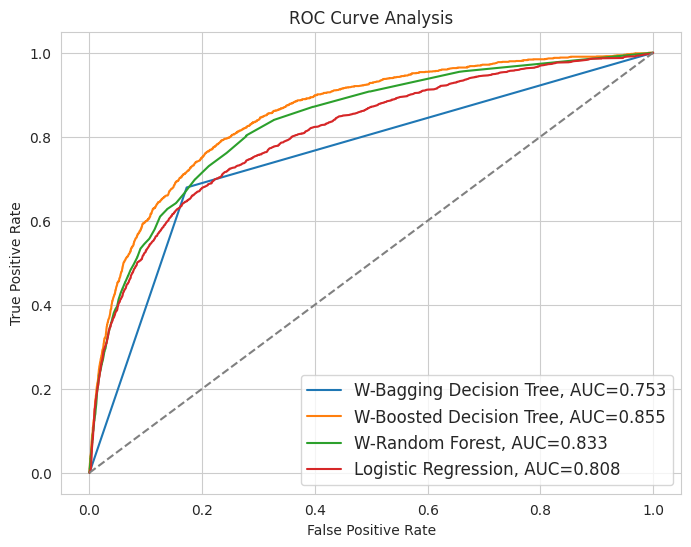

In [288]:
#RUN TIME DISCLAIMER: 1 MINUTE
#style settings
sns.set_style("whitegrid")
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob_baseline)
auc = roc_auc_score(y_test, y_pred_prob_baseline)
df_plot.loc[len(df_plot)] = {'classifiers':"Logistic Regression",
                                        'fpr':fpr,
                                        'tpr':tpr,
                                        'auc':auc}

#plot the figure
fig, ax = plt.subplots(figsize=(8, 6))
for i in df_plot.index:
    sns.lineplot(x=df_plot.loc[i]['fpr'], y=df_plot.loc[i]['tpr'], label="{}, AUC={:.3f}".format(df_plot.loc[i]['classifiers'], df_plot.loc[i]['auc']))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title="ROC Curve Analysis")
ax.legend(prop={'size': 12}, loc='lower right')
plt.savefig("roc_curve_weights.png", dpi=1200)
plt.show()

In the graph are displayed the ROC curves of each
of the weighted techniques, and we can see that there is
a very good performance for the weighted boosted (with
an AUC of 0.855) while a decrease in predictability of
the bagging model. This underperformance could be
caused by an overfitting of the model or derived by an
overpenalization of the negative class of our target variable, that could make our algorithm converge into a suboptimal solution.

## 3) Algorithm-level techniques

In [289]:
#RUN TIME DISCLAIMER: 40 SECONDS
classifiers = {
    'Easy Ensemble': EasyEnsembleClassifier(random_state=42),
    'Balanced Random Forest': BalancedRandomForestClassifier(random_state=42),
    'Balanced Bagging': BalancedBaggingClassifier(random_state=42),
}

#loop over the results
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    #compute the metrics and store them
    accuracy = clf.score(X_test, y_test)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    accuracies[name] = clf.score(X_test, y_test)
    recalls[name] = recall
    f1s[name] = f1
    aucs[name] = auc

    results[name] = {"accuracy": accuracy, "recall": recall, "f1": f1, "auc": auc}

#print the results
print("{:<25} {:<10} {:<10} {:<10} {:<10}".format("Classifier", "Accuracy", "Recall", "F1-score", "AUC"))
print("-" * 65)
for name, scores in results.items():
    print("{:<25} {:.4f}     {:.4f}     {:.4f}     {:.4f}".format(name, scores["accuracy"], scores["recall"], scores["f1"], scores["auc"]))

Classifier                Accuracy   Recall     F1-score   AUC       
-----------------------------------------------------------------
Easy Ensemble             0.8002     0.7422     0.3273     0.8556
Balanced Random Forest    0.7844     0.7720     0.3193     0.8523
Balanced Bagging          0.8367     0.6194     0.3320     0.8219


## (Augmentation + Ensembling)

In our search for solutions to unbalanced binary classification, we found an intriguing paper examining resampling+ensembling combination methods. It
provides performance data on various combinations for
6
datasets like Glass, Yeast, and Ecoli. We identified similarities between our dataset and one present in the study,
particularly with Glass-6, where ROS+Adaboost and
SMOTE+RandomForest showed excellent performance

In [290]:
#percentage of minority and majority
minority_percentage = (df_train["SeriousDlqin2yrs"] == 1).mean() * 100
print("Percentage of minority class:", minority_percentage)

majority_percentage = (df_train["SeriousDlqin2yrs"] == 0).mean() * 100
print("Percentage of majority class:", majority_percentage)

#get the imbalance ratio and the number of attributes
positive_instances = (df_train["SeriousDlqin2yrs"] == 1).sum()
negative_instances = (df_train["SeriousDlqin2yrs"] == 0).sum()
imbalance_ratio = negative_instances / positive_instances
print("Imbalance Ratio:", imbalance_ratio)

print("Number of attributes: ", X.shape[1])


Percentage of minority class: 6.500636537237428
Percentage of majority class: 93.49936346276257
Imbalance Ratio: 14.383108935128519
Number of attributes:  13


**Closest match: Glass-6**

### ROS + AdaBoost

In [291]:
adaboost_clf = AdaBoostClassifier(n_estimators=50,learning_rate=1.0,random_state=42)

#define a pipeline with ROS and adaboost
ros_pipeline = Pipeline([
    ('ros', RandomOverSampler(random_state=42)),
    ('adaboost', adaboost_clf)
])

#train the pipeline and get the prediction on the test
ros_pipeline.fit(X_train, y_train)
y_pred = ros_pipeline.predict(X_test)

#compute the metrics and print them
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, ros_pipeline.predict_proba(X_test)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("AUC:", auc)
print("Normalized Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.8034666666666667
F1 Score: 0.3336347197106691
AUC: 0.8562188656778369
Normalized Confusion Matrix:
[[0.80714354 0.19285646]
 [0.24898236 0.75101764]]


### SMOTE + Random Forest

In [292]:
#RUN TIME DISCLAIMER: 50 SECONDS
#resample with SMOTE
smote = SMOTE(sampling_strategy="auto", k_neighbors=5, n_jobs=None, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#initialize the random forest,train it and get the predictions
rf_classifier = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=None, max_leaf_nodes=None, n_jobs=None, random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)
y_pred = rf_classifier.predict(X_test)

#compute the metrics and print them
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("AUC:", auc)
print("Normalized Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9310666666666667
F1 Score: 0.31643895989422655
AUC: 0.8287425460575336
Normalized Confusion Matrix:
[[0.97926377 0.02073623]
 [0.75644505 0.24355495]]


# Selection of top 3 and shallow fine tuning

Final table of results

In [293]:
final_results = pd.DataFrame([accuracies, recalls, f1s, aucs])
final_results = final_results.transpose()
final_results.columns = ['Accuracy', 'Recall', 'F1', 'AUC']
final_results_sorted = final_results.sort_values(by='AUC', ascending=False)
final_results_sorted

,Accuracy,Recall,F1,AUC
RUS + Boosted Decision Tree,0.795200,0.757802,0.326513,0.856429
Easy Ensemble,0.800178,0.742198,0.327349,0.855622
ROS + Boosted Decision Tree,0.802578,0.746947,0.331427,0.854621
W-Boosted Decision Tree,0.804844,0.740841,0.332167,0.854523
Boosted Decision Tree,0.936000,0.234735,0.324578,0.853982
SMOTE + Boosted Decision Tree,0.936000,0.234735,0.324578,0.853982
Balanced Random Forest,0.784400,0.772049,0.319349,0.852256
RUS + Random Forest,0.782933,0.763908,0.315583,0.847231
SMOTE + Random Forest,0.934756,0.191995,0.278269,0.834271
W-Random Forest,0.934444,0.124830,0.199674,0.833313


The best models according to the AUC score (given by the assignment) are:
1. RUS + Boosted decision tree
2.Easy ensemble
3.ROS + Boosted decision tree

Now we proceeed with the finetuning of each of them, in order to boost their performances even more.


## 1. RUS + Boosted Decision Tree

In [294]:
#RUN TIME DISCLAIMER: 2 MINUTES
rus_boosted_pipeline = Pipeline([
    ('rus', RandomUnderSampler(random_state=42)),
    ('boosted_dt', AdaBoostClassifier(random_state=42))
])

#set the grid
param_grid = {
    'rus__sampling_strategy': ['auto', 'not minority', 'all'],
    'boosted_dt__n_estimators': [50, 100],
    'boosted_dt__learning_rate': [0.01, 0.1, 1]
}

#perform the GridSearch
grid_search = GridSearchCV(rus_boosted_pipeline, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

#Store the best parameters and best score
best_params = grid_search.best_params_
best_auc_roc = grid_search.best_score_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [295]:
best_params

{'boosted_dt__learning_rate': 0.1,
 'boosted_dt__n_estimators': 100,
 'rus__sampling_strategy': 'auto'}

In [296]:
#re-train the model using the obtained best parameters
rus_boosted_pipeline = Pipeline([
    ('rus', RandomUnderSampler(sampling_strategy='auto', random_state=42)),
    ('boosted_dt', AdaBoostClassifier(n_estimators = 100 , learning_rate = 0.1, random_state=42))])

rus_boosted_pipeline.fit(X_test, y_test)
y_pred_proba_RUS = rus_boosted_pipeline.predict_proba(X_test)[:, 1]

#compute the metrics and print them
test_auc_roc = roc_auc_score(y_test, y_pred_proba_RUS)

print("Best Parameters:", best_params)
print("Best AUC ROC on Cross Validation:", best_auc_roc)
print("AUC ROC on Test Set:", test_auc_roc)

Best Parameters: {'boosted_dt__learning_rate': 0.1, 'boosted_dt__n_estimators': 100, 'rus__sampling_strategy': 'auto'}
Best AUC ROC on Cross Validation: 0.8558451346093501
AUC ROC on Test Set: 0.8582877650607936


## 2. Easy Ensemble

In [297]:
#RUN TIME DISCLAIMER: 14 MINUTES
ee_classifier = EasyEnsembleClassifier()

# set the grid
param_grid = {
    'n_estimators': [20, 30, 50],
    'replacement' : [True, False]
}

#perform the GridSearch
grid_search = GridSearchCV(ee_classifier, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

#get the best parameters and best score
best_params = grid_search.best_params_
best_auc_roc = grid_search.best_score_

#Re-train the model with the best parameters obtained
best_ee_classifier = EasyEnsembleClassifier(**best_params)
best_ee_classifier.fit(X_train, y_train)

y_pred_proba_ee = best_ee_classifier.predict_proba(X_test)[:, 1]

#compute the metrics and print them
test_auc_roc = roc_auc_score(y_test, y_pred_proba_ee)

print("Best Parameters:", best_params)
print("Best AUC ROC on Cross Validation:", best_auc_roc)
print("AUC ROC on Test Set:", test_auc_roc)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 30, 'replacement': False}
Best AUC ROC on Cross Validation: 0.8581964457442626
AUC ROC on Test Set: 0.8560238173813619


## 3. ROS + Boosted Decision Tree


In [298]:
#RUN TIME DISCLAIMER: 15 MINUTES
ROS_pipeline = Pipeline([
    ('ros', RandomOverSampler(random_state=42)),
    ('boosted_dt', AdaBoostClassifier(random_state=42))
])

#set the grid
param_grid = {
    'ros__sampling_strategy': ['auto', 'minority', 'not minority'],
    'boosted_dt__n_estimators': [50, 100],
    'boosted_dt__learning_rate': [0.01, 0.1, 1]
}

#perform the gridsearch
grid_search = GridSearchCV(ROS_pipeline, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

#store the best parameters and best score
best_params = grid_search.best_params_
best_auc_roc = grid_search.best_score_



Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [299]:
best_params

{'boosted_dt__learning_rate': 1,
 'boosted_dt__n_estimators': 100,
 'ros__sampling_strategy': 'auto'}

In [300]:
#Re-rain the model with the best parameters obtained
best_ROS_pipeline = Pipeline([
    ('ros', RandomOverSampler(sampling_strategy=best_params['ros__sampling_strategy'], random_state=42)),
    ('boosted_dt', AdaBoostClassifier(n_estimators = 100 , learning_rate = 1, random_state=42))
])
best_ROS_pipeline.fit(X_train, y_train)

y_pred_proba_ROS = best_ROS_pipeline.predict_proba(X_test)[:, 1]

#compute the metrics and print them
test_auc_roc = roc_auc_score(y_test, y_pred_proba_ROS)

print("Best Parameters:", best_params)
print("Best AUC ROC on Cross Validation:", best_auc_roc)
print("AUC ROC on Test Set:", test_auc_roc)

Best Parameters: {'boosted_dt__learning_rate': 1, 'boosted_dt__n_estimators': 100, 'ros__sampling_strategy': 'auto'}
Best AUC ROC on Cross Validation: 0.8577267620826007
AUC ROC on Test Set: 0.8569569193972029


# Comparison

## Plots
ROC curve and Confusion matrices

In [301]:
classifiers_proba = [("RUS+Adaboost", y_pred_proba_RUS), ("EE", y_pred_proba_ee), ("ROS+Adaboost", y_pred_proba_ROS)]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for pair in classifiers_proba:
    fpr, tpr, _ = roc_curve(y_test,  pair[1])
    auc = roc_auc_score(y_test, pair[1])
    result_table.loc[len(result_table)] = {'classifiers':pair[0],
                                        'fpr':fpr,
                                        'tpr':tpr,
                                        'auc':auc}

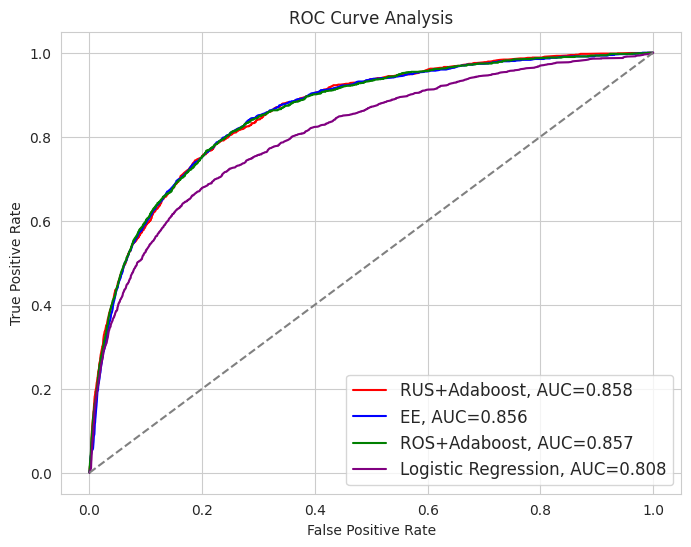

In [302]:
#RUN TIME DISCLAIMER: 1 MINUTES
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob_baseline)
auc = roc_auc_score(y_test, y_pred_prob_baseline)
result_table.loc[len(result_table)] = {'classifiers':"Logistic Regression",
                                        'fpr':fpr,
                                        'tpr':tpr,
                                        'auc':auc}
result_table.set_index('classifiers', inplace=True)

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
colors = ["red", "blue", "green", "purple"]

#plot the curves
for j, i in enumerate(result_table.index):
    sns.lineplot(x=result_table.loc[i]['fpr'],
                 y=result_table.loc[i]['tpr'], color=colors[j],
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title="ROC Curve Analysis")

ax.legend(prop={'size': 12}, loc='lower right')
plt.savefig("roc_curve_last3.png", dpi=1200)

plt.show()

## Confusion matrices

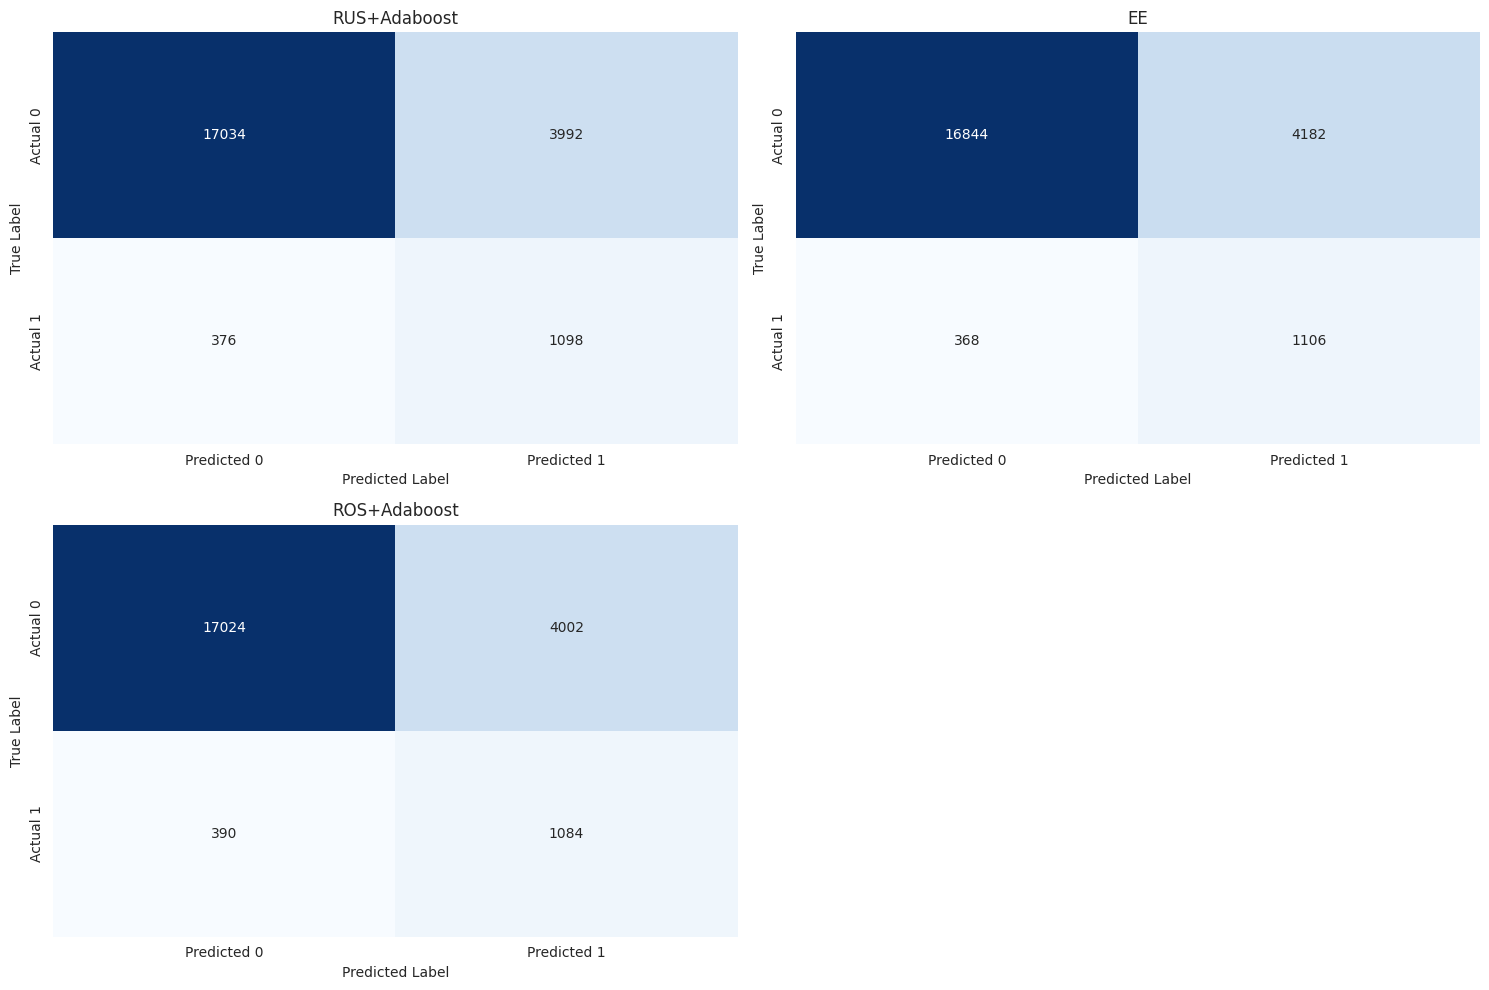

In [303]:
plt.figure(figsize=(15, 10))
for i, pair in enumerate(classifiers_proba, 1):
    plt.subplot(2, 2, i)
    plt.title(pair[0])
    cm = confusion_matrix(y_test, pair[1] > 0.5)  # Assuming threshold is 0.5
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
plt.tight_layout()
plt.show()

Feature importance of the best: RUS + Boosted decision tree

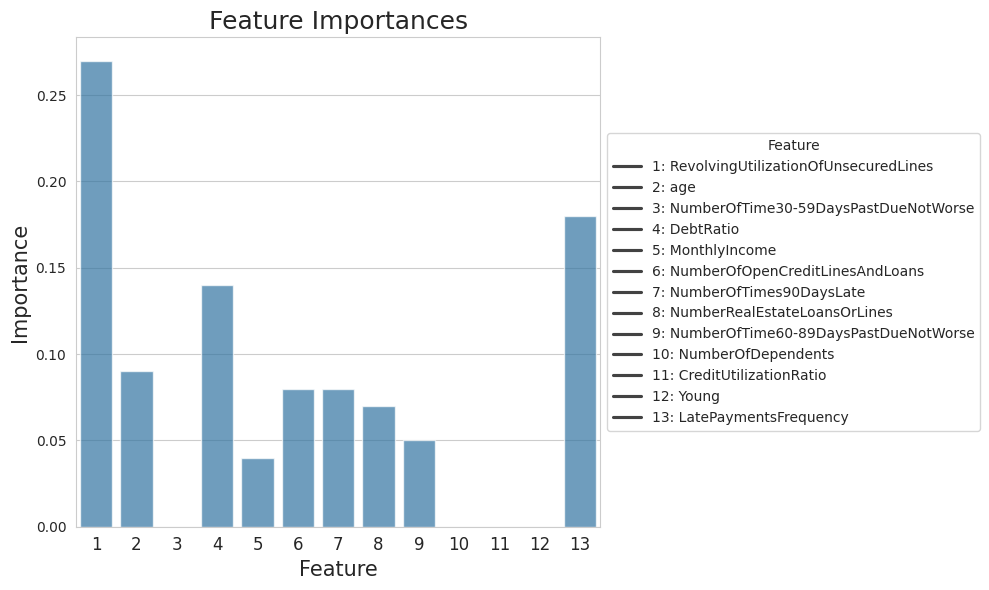

In [304]:
feature_importances = rus_boosted_pipeline.steps[1][1].feature_importances_
features = X_train.columns.array

plt.figure(figsize=(10, 6))
sns.barplot(x=range(len(features)), y=feature_importances, alpha=0.7)

plt.xticks(ticks=range(len(features)), labels=range(1, len(features) + 1), fontsize=12)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.title('Feature Importances', fontsize=18)
labels = [f'{i+1}: {feature}' for i, feature in enumerate(features)]
plt.legend(labels, title="Feature", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.tight_layout()
plt.savefig("features_imp.png", dpi=1200)
plt.show()


# Submission

Computing the predictions on the data given and exporting them

In [305]:
df_test = df.drop(df.columns[0],axis=1)
df_final_submission=pd.DataFrame(rus_boosted_pipeline.predict_proba(df_test)[:, 1])
df_final_submission.to_csv('final_submission.csv', index_label='Id')

By taking a quick look at the predicted probabilities we see that they are all approximately in the range [0.4,0.6], it is likely that the model do not have high level of confidence but can distinguish clearly when used 0.5 as a decision threshold as shown by the recall metric(0.75).